# N04. Proyección de oferta de energía hidráulica (ofertaEnergiaHidro)
Se realizará la proyección de 'Aportes de energía hidráulica (energía)' para los próximos 78 meses.
Esta proyección se basará en lo siguiente:

* Se encontrará la relación entre 'Aportes de energía hidráulica (energía)' y 'Aportes de energía hidráulica (caudal)'.
* Se contrará la relación y la 'Diferencia de aportes' entre los 'Aportes de energía hidráulica históricos' y 'Aportes de energía hidráulica real'.
* Se encontrará la relación entre el MEI y la 'Diferencia de aportes'.

Se crearán inicialmente dos DataFrame: 'aportes' y 'capacidad'.

## 4.1. Carga paquetes para la proyección 

In [2]:
#*******************************************************************************       
# 4.1.1. Carga paquetes requeridos para leer en base de datos y proyección.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 4.2. Aportes de caudales y energía de caudales
El DataFrame 'aportes' incluirá las siguientes variables, las cuales se transformarán en variables mensuales:
* AporEner
* AporEnerMediHist
* AporCaudalRio
* AporCaudalMediHistRio

* AporCaudalRio (m3/s). Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo.

* AporCaudalMediHistRio (m3/s). Caudal medio mensual histórico para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles.

* AporEner (kWh). Caudales en energia de los rios que aportan agua a algun embalse del SIN (Sistema).

* AporEnerRio (kWh). Caudales en energia de los rios que aportan agua a algun embalse del SIN (Río).

* AporEnerMediHist	Aportes Media Histórica Energía	Sistema

* AporEnerMediHist (kWh). Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles (Sistema).

* AporCaudalMediHistRio (kWh). Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles (Río).


In [4]:
#*******************************************************************************       
# 4.2.1. Crea la máquina para conectarse a la base de datos dbXm.db.
#*******************************************************************************
engine = create_engine('sqlite:///dbXm.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()

In [71]:
#*******************************************************************************       
# 4.2.2. Lee las variables de 'aportes' y ajusta.
#*******************************************************************************
tablas = ['AporEner', 'AporEnerMediHist', \
    'AporEnerRio', 'AporEnerMediHistRio', \
        'AporCaudalRio', 'AporCaudalMediHistRio']
nombresDf = ['aporEner', 'aporEnerMediHist', \
    'aporEnerRio', 'aporEnerMediHistRio', \
        'aporCaudalRio', 'aporCaudalMediHistRio']
df = {}

for i, tabla in  enumerate(tablas):
    consulta = "SELECT * FROM " + tabla
    df[nombresDf[i]] = pd.read_sql(consulta, engine, parse_dates=["Date"])
#Ajusta las columnas, los índices y los nombres de los DataFrames.
for i, nombre in  enumerate(nombresDf):
   df[nombre] = df[nombre].iloc[:, 1:] if i <= 1 else df[nombre].iloc[:, [1, 3]]
   df[nombre] = df[nombre].set_index('Date')
   df[nombre].columns = [nombre]
   df[nombre + '_m'] = df[nombre] #Crea los contenedores DataFrame mensuales.

In [72]:
#*******************************************************************************       
# 4.2.3. Agrupa los valores para obtener los valores de mensuales.
#*******************************************************************************
for i, nombre in  enumerate(nombresDf):
    if i <= 1: #Diarios, por Sistema.
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby(pd.to_datetime(df[nombre + '_m'].index)\
                .to_period('M')).mean()
    else: #Diarios, por ríos.
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby(pd.to_datetime(df[nombre + '_m'].index).\
                to_period('D')).sum()
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby((df[nombre + '_m'].index)\
                .to_timestamp().to_period('M')).mean()
    #
    df[nombre + '_m'].index = df[nombre + '_m'].index.to_timestamp()


In [117]:
#*******************************************************************************       
# 4.2.4. Integra las tablas de base de datos en un DataFrame aportes_m.
#*******************************************************************************
# # aportes_m = df['aporEner_m']/1e6
# nombresDf_m = ['aporEnerMediHist_m', \
#     'aporEnerRio_m', 'aporEnerMediHistRio_m', \
#         'aporCaudalRio_m', 'aporCaudalMediHistRio_m']
# for i, nombre in enumerate(nombresDf_m):
#     if i == 0:
#         aportes_m = pd.merge(aportes_m, df[nombre]/1e6, left_on="Date", right_on="Date")
#     else:
#         aportes_m = pd.merge(aportes_m, df[nombre], left_on="Date", right_on="Date")

# aportes_m = aportes_m.drop(columns=['aporEnerRio', 'aporEnerMediHistRio'])
# aportes_m.insert(loc=len(aportes_m.columns), column="diferenciaAportes", \
#     value=(aportes_m['aporEner'] - aportes_m['aporEnerMediHist']).values, \
#         allow_duplicates=True)

In [31]:
#*******************************************************************************
# 4.2.5. Salva  y lee aportes_m.
#*******************************************************************************
#Salva pbmCpe
# aportes_m.to_parquet('parquet/aportes_m.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee pbmCpe
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

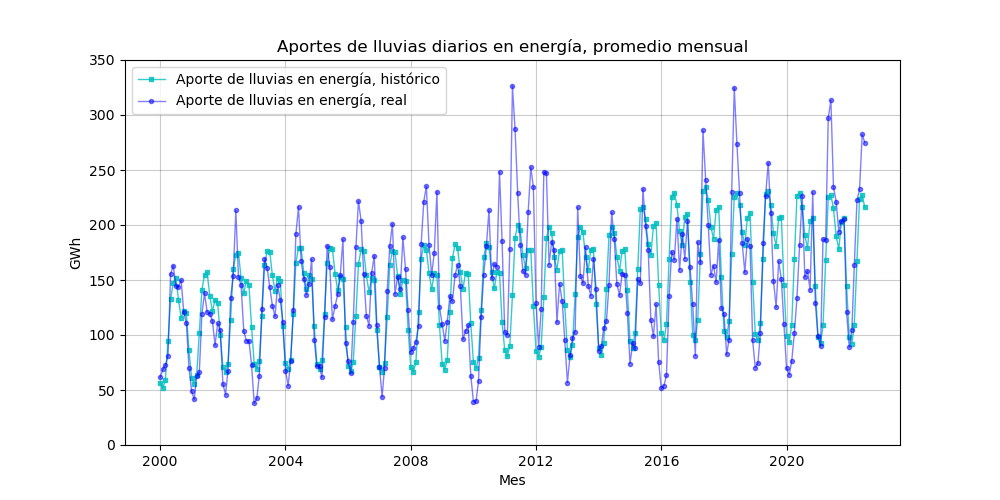

In [33]:
#*******************************************************************************
# 4.2.6. Grafica aportes_m.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de lluvias diarios en energía, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.aporEnerMediHist, 'c-s', \
    label='Aporte de lluvias en energía, histórico', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label='Aporte de lluvias en energía, real', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

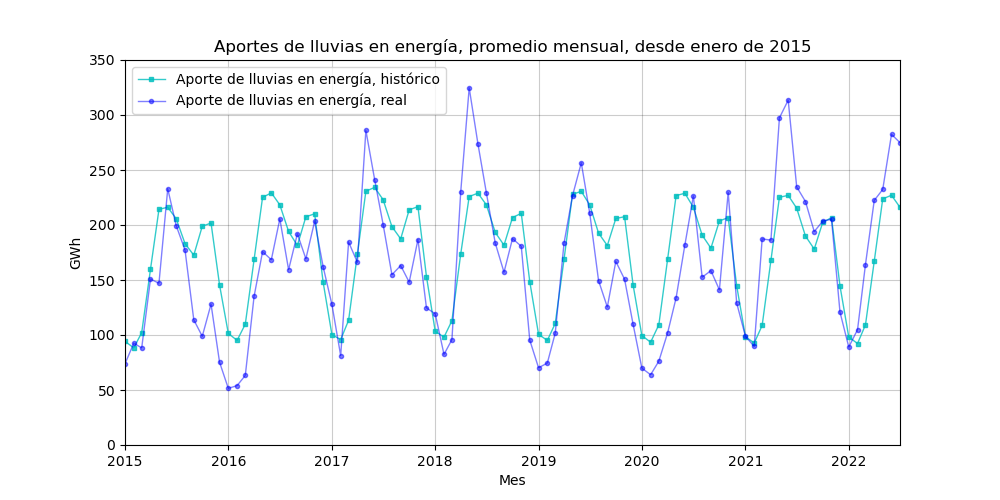

In [195]:
#*******************************************************************************
# 4.2.7. Grafica aportes_m desde 2015-01.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de lluvias en energía, promedio mensual, desde enero de 2015')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.aporEnerMediHist, 'c-s', \
    label='Aporte de lluvias en energía, histórico', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label='Aporte de lluvias en energía, real', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

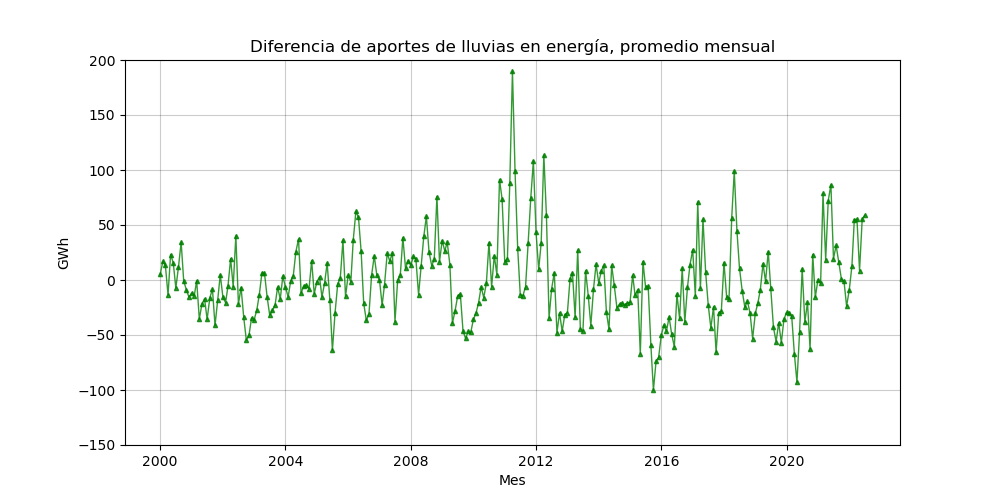

In [197]:
#*******************************************************************************
# 4.2.8. Grafica diferencia de aportes de lluvia, promedio mensual.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Diferencia de aportes de lluvias en energía, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.diferenciaAportes, 'g-^', \
    label='Diferencia de aporte de lluvias en energía', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(-150, 200)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

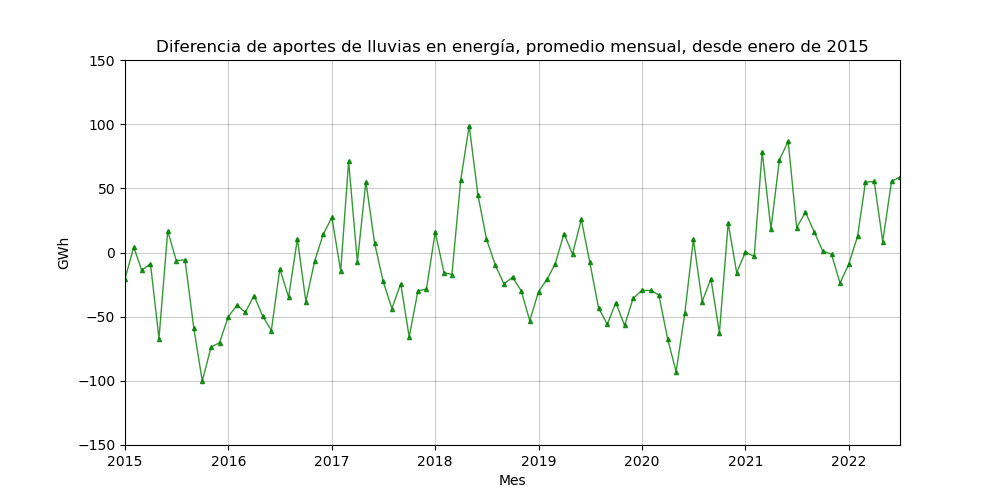

In [198]:
#*******************************************************************************
# 4.2.9. Grafica diferencia de aportes de lluvia, desde enero de 2015.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Diferencia de aportes de lluvias en energía, promedio mensual, desde enero de 2015')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.diferenciaAportes, 'g-^', \
    label='Diferencia de aporte de lluvias en energía', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(-150, 150)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

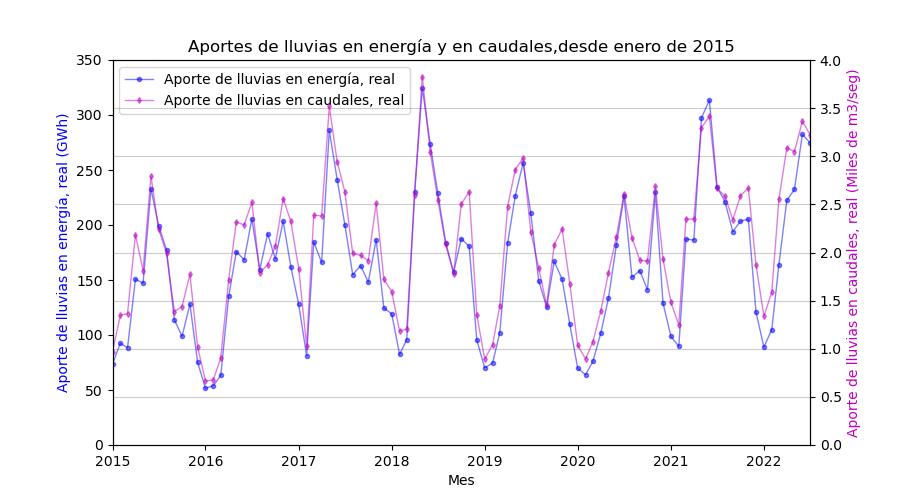

In [202]:
#*******************************************************************************
# 4.2.10. Grafica aporEner Vs aporCaudalRio desde 2015-01.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
ax2 = ax1.twinx()

ax1.set_title ('Aportes de lluvias en energía y en caudales,desde enero de 2015')

ax1.set_xlabel("Mes")
ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
ax2.set_ylabel("Aporte de lluvias en caudales, real (Miles de m3/seg)", color='m')

linea1 = ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label="Aporte de lluvias en energía, real", \
        linewidth=1, markersize=3, alpha=0.5)

linea2 = ax2.plot(aportes_m.index, aportes_m.aporCaudalRio/1e3, 'm-d', \
    label="Aporte de lluvias en caudales, real", linewidth=1, \
        markersize=3, alpha=0.5)


# added these three lines
lineas = linea1 + linea2
etiquetas = [l.get_label() for l in lineas]
ax1.legend(lineas, etiquetas, loc='best')

plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
#plt.ylim(0, 400)
#plt.par.ylim(0, 400)
ax1.set_ylim(0, 350)
ax2.set_ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [203]:
#*******************************************************************************
# 4.2.11. Calcula el coeficiente de correlación entre aporCaudalRio Vs aporEner.
#*******************************************************************************
import scipy.stats
# aportes_m.aporCaudalRio.corr(aportes_m.aporEner) #0.9375
r, p = scipy.stats.pearsonr(aportes_m.aporCaudalRio, aportes_m.aporEner)
r, p # r (correlación de Pearson): 0.9375; valor p: 0.
#(0.9375748320891986, 2.1212045210040593e-125)

(0.9375748320891986, 2.1212045210040593e-125)

In [37]:
#*******************************************************************************
# 4.2.12. Calcula la regresión entre la dispersión de aporCaudalRio Vs aporEner.
#*******************************************************************************
m, b = np.polyfit(aportes_m.aporCaudalRio, aportes_m.aporEner, 1)
aportes_m.insert(5, 'aporEner_hat', aportes_m.aporCaudalRio*m + b, allow_duplicates=True) 
# aportes_m
# m, b
# m = 0.08577574033953389
# b = -5.7997463853853946
# m * X + b

(0.08577574033953389, -5.7997463853853946)

In [36]:
aportes_m

aporEner  aporEnerMediHist  aporCaudalRio  \
Date                                                      
2000-01-01   61.694410             56.51     885.310000   
2000-02-01   68.747062             51.68     981.601379   
2000-03-01   72.714977             59.40    1088.773548   
2000-04-01   81.174443             94.73     999.509000   
2000-05-01  155.569142            132.41    1724.152581   
...                ...               ...            ...   
2022-03-01  164.075668            109.23    2552.591613   
2022-04-01  222.358797            167.03    3088.581000   
2022-05-01  232.307732            223.76    3047.230645   
2022-06-01  282.403320            227.05    3365.498000   
2022-07-01  274.881233            216.05    3225.775333   

            aporCaudalMediHistRio  diferenciaAportes  aporEner_hat  
Date                                                                
2000-01-01                 709.78           5.184410     70.138374  
2000-02-01                 683.42          17.067062     78.397839  
2000-03-01                 762.83          13.314977     87.590611  
2000-04-01                1045.92         -13.555557     79.933878  
2000-05-01                1272.38          23.159142    142.090718  
...                           ...                ...           ...  
2022-03-01                1555.65          54.845668    213.150689  
2022-04-01                2301.56          55.328797    259.125575  
2022-05-01                2930.55           8.547732    255.578718  
2022-06-01                2795.26          55.353320    282.878336  
2022-07-01                2574.55          58.831233    270.893521  

[271 rows x 6 columns]

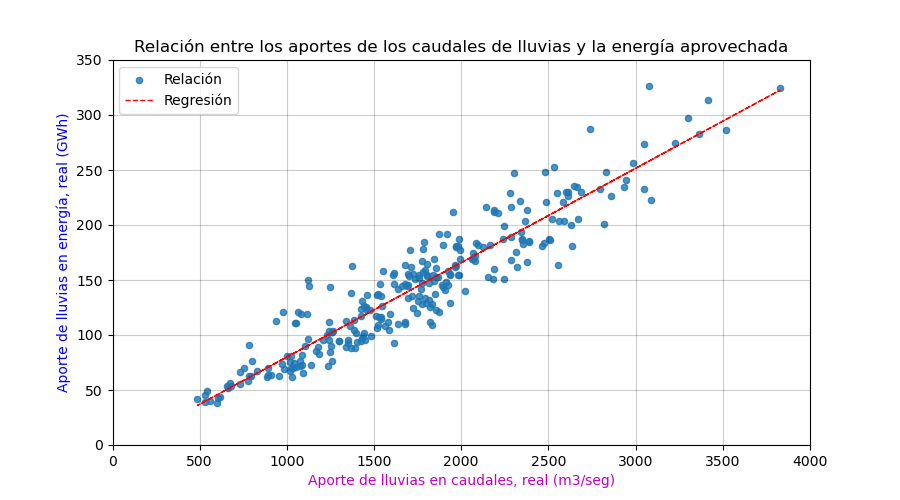

In [35]:
#*******************************************************************************
# 4.2.12. Grafica dispersión de aporCaudalRio Vs aporEner con la regresión.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.

ax1.set_title ('Relación entre los aportes de los caudales de lluvias y la energía aprovechada')

# ax1.set_xlabel("Mes")
# ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# ax2.set_ylabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')

plt.scatter(aportes_m.aporCaudalRio, aportes_m.aporEner, label='Relación', \
    alpha=0.8, s=20, marker="o")
ax1.plot(aportes_m.aporCaudalRio, aportes_m.aporEner_hat, 'r--', \
    label='Regresión', linewidth=1)
plt.xlabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')
plt.ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 350)
plt.xlim(0, 4000)
# plt.par.ylim(0, 400)
#plt.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.legend(loc='best')
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

La relación es: aporEner = (aporCaudalRio * 0.0857) - 5.799 

## 4.3. Relación entre el MEI  y los 'Aportes de caudales de lluvia reales' 

In [24]:
#*******************************************************************************
# 4.3.1. Lee el meiT y aportes_m.
#*******************************************************************************
meiT = pd.read_parquet('parquet/meiT.parquet.gzip', engine='fastparquet')
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

In [25]:
#*******************************************************************************
# 4.3.2. Acondiciona meiT para poder comparar relacionar con aportes_m.
#*******************************************************************************
mei_real = meiT.loc[meiT['mei'].notna(), 'mei']
mei_real.index.name = 'Date'
caudal_mei = pd.merge(aportes_m.aporCaudalRio/1e3, mei_real, left_on="Date", right_on="Date")
caudal_mei = pd.merge(caudal_mei, aportes_m.aporCaudalMediHistRio/1e3, left_on="Date", right_on="Date")
# caudal_mei

In [26]:
#*******************************************************************************
# 4.3.3. Corrige valores atípicos de aporCaudalMediHistRio.
#*******************************************************************************
# caudal_mei.loc[pd.to_datetime('2013-05-01'), 'aporCaudalMediHistRio'] #3.41
# caudal_mei.loc[pd.to_datetime('2015-10-01'), 'aporCaudalMediHistRio'] #5.20
# caudal_mei.loc[pd.to_datetime('2015-11-01'), 'aporCaudalMediHistRio'] #5.29
# caudal_mei.loc[pd.to_datetime('2015-12-01'), 'aporCaudalMediHistRio'] #4.07
#
# caudal_mei.loc[pd.to_datetime('2014-05-01'), 'aporCaudalMediHistRio'] #2.13
# caudal_mei.loc[pd.to_datetime('2016-10-01'), 'aporCaudalMediHistRio'] #2.63
# caudal_mei.loc[pd.to_datetime('2016-11-01'), 'aporCaudalMediHistRio'] #2.80
# caudal_mei.loc[pd.to_datetime('2016-12-01'), 'aporCaudalMediHistRio'] #2.05
#
caudal_mei_c = caudal_mei.copy()
caudal_mei_c.loc['2013-05-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2014-05-01', 'aporCaudalMediHistRio']
caudal_mei_c.loc['2015-10-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2016-10-01', 'aporCaudalMediHistRio']
caudal_mei_c.loc['2015-11-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2016-11-01', 'aporCaudalMediHistRio']
caudal_mei_c.loc['2015-12-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2016-12-01', 'aporCaudalMediHistRio']
caudal_mei = caudal_mei_c  

In [27]:
#*******************************************************************************
# 4.3.4. Calcula mei1 (un retardo en el mei).
#*******************************************************************************
caudal_mei.insert(3, column='mei1', value=caudal_mei.mei.shift(), allow_duplicates=True)
caudal_mei = caudal_mei.dropna()

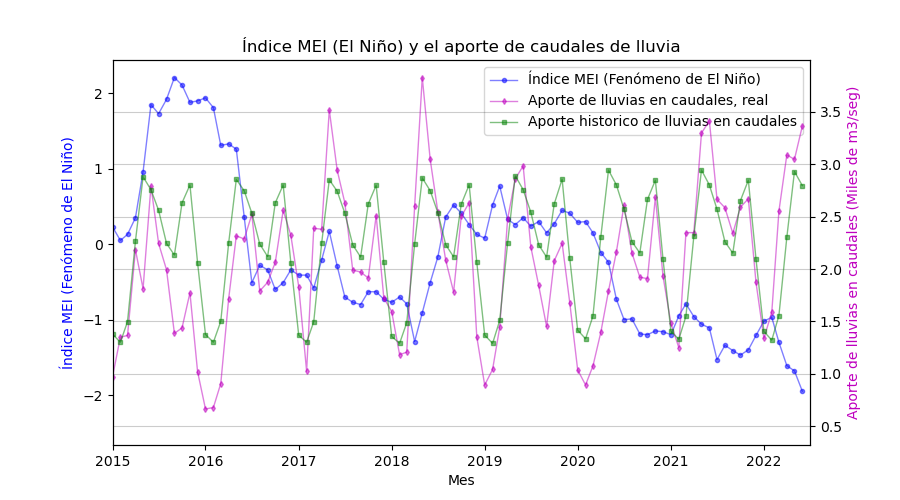

In [81]:
#*******************************************************************************
# 4.3.5. Grafica mei, aportCaudalRio y aporCaudalMediHistRio.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
ax2 = ax1.twinx()

ax1.set_title ("Índice MEI (El Niño) y el aporte de caudales de lluvia")

ax1.set_xlabel("Mes")
ax1.set_ylabel("Índice MEI (Fenómeno de El Niño)", color='b')
ax2.set_ylabel("Aporte de lluvias en caudales (Miles de m3/seg)", color='m')

linea1 = ax1.plot(caudal_mei.index, caudal_mei.mei, 'b-o', \
    label="Índice MEI (Fenómeno de El Niño)", \
        linewidth=1, markersize=3, alpha=0.5)

linea2 = ax2.plot(caudal_mei.index, caudal_mei.aporCaudalRio, 'm-d', \
    label="Aporte de lluvias en caudales, real", linewidth=1, \
        markersize=3, alpha=0.5)

linea3 = ax2.plot(caudal_mei.index, caudal_mei.aporCaudalMediHistRio, 'g-s', \
    label="Aporte historico de lluvias en caudales", linewidth=1, \
        markersize=3, alpha=0.5)

# added these three lines
lineas = linea1 + linea2 + linea3
etiquetas = [l.get_label() for l in lineas]
ax1.legend(lineas, etiquetas, loc='best')

# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-06-01'))
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
#plt.ylim(0, 400)
#plt.par.ylim(0, 400)
# ax1.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [83]:
#*******************************************************************************
# 4.3.6. Calcula coeficiente de correlación entre mei y aporCaudalRio.
#*******************************************************************************
import scipy.stats
r, p = scipy.stats.pearsonr(caudal_mei.mei, caudal_mei.aporCaudalRio)
#r, p # r (correlación de Pearson): -0.3067; valor p: 0.
#mei: (-0.31433351138495325, 1.3979868319505354e-07)
#mei1: (-0.32745039954951416, 4.075025773408061e-08)
#mei2: (-0.30851561209096595, 2.559915197528141e-07)


In [28]:
#*******************************************************************************
# 4.3.7. Calcula la regresión entre caudal_mei.mei Vs caudal_mei.aporCaudalRio.
#*******************************************************************************
a, b, c = np.polyfit(caudal_mei.mei, caudal_mei.aporCaudalRio, 2) #grado 2.
caudal_mei.insert(4, 'aporCaudalRio_hat',  \
    a * np.square(caudal_mei.mei) + b * caudal_mei.mei + c, allow_duplicates=True) 
# caudal_mei
# a, b, c
# (0.056633704635569736, -0.21706142481276552, 1.6296385955059782)

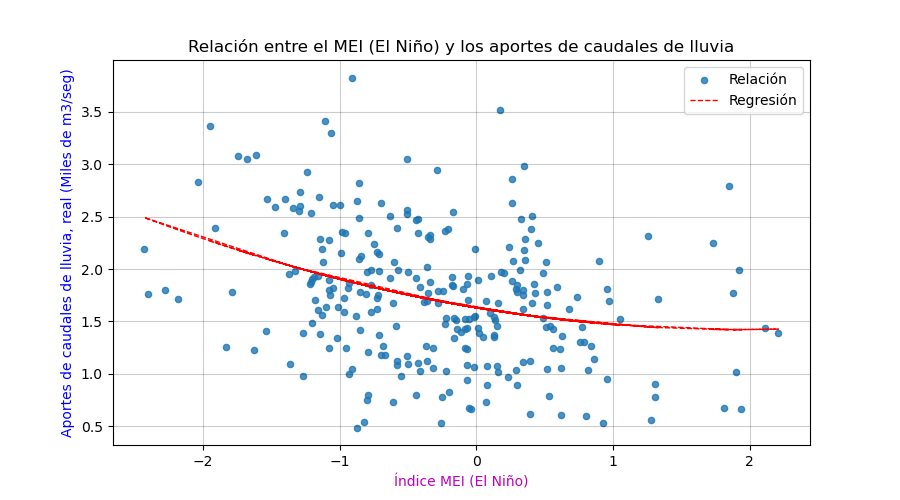

In [85]:
#*******************************************************************************
# 4.3.8. Gráfica de dispersión de mei Vs aporCaudalRio, con la regresión.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.

ax1.set_title ('Relación entre el MEI (El Niño) y los aportes de caudales de lluvia')

# ax1.set_xlabel("Mes")
# ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# ax2.set_ylabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')

plt.scatter(caudal_mei.mei, caudal_mei.aporCaudalRio, label='Relación', \
    alpha=0.8, s=20, marker="o")
ax1.plot(caudal_mei.mei, caudal_mei.aporCaudalRio_hat, 'r--', \
    label='Regresión', linewidth=1)
plt.xlabel("Índice MEI (El Niño)", color='m')
plt.ylabel("Aportes de caudales de lluvia, real (Miles de m3/seg)", color='b')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
# plt.ylim(0, 350)
# plt.xlim(0, 4000)
# plt.par.ylim(0, 400)
#plt.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.legend(loc='best')
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.4. Modelo entre el MEI + 'Aportes de caudales históricos' con los 'Aportes de caudales de lluvia reales' 

In [29]:
#*******************************************************************************
# 4.4.1. Modelo de regresión lineal aporCaudalRio ~ mei + aporCaudalMediHistRio.
#*******************************************************************************
regresion_lineal = smf.ols(formula = 'aporCaudalRio ~ mei + aporCaudalMediHistRio', data=caudal_mei)
modelo_ajustado_caudal = regresion_lineal.fit()
modelo_ajustado_caudal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          aporCaudalRio   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     341.3
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           3.59e-74
Time:                        17:23:17   Log-Likelihood:                -86.508
No. Observations:                 269   AIC:                             179.0
Df Residuals:                     266   BIC:                             189.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0220      0.071      0.308      0.758      -0.118       0.162
mei                      -0.2603      0.024    -10.739      0.000      -0.308      -0.213
aporCaudalMediHistRio     0.9139      0.038     24.267      0.000       0.840       0.988
==============================================================================
Omnibus:                       14.032   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.770
Skew:                           0.474   Prob(JB):                     0.000376
Kurtosis:                       3.713   Cond. No.                         8.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
#*******************************************************************************
# 4.4.2. Salva  y lee el modelo_ajustado_caudal.
#*******************************************************************************
#Salva modelo_ajustado_caudal
# modelo_ajustado_caudal.save('modelos/modelo_ajustado_caudal.pickle')
#Lee modelo_ajustado_caudal
modelo_ajustado_caudal = sm.load('modelos/modelo_ajustado_caudal.pickle')

In [31]:
#*******************************************************************************
# 4.4.3. Matriz de correlación.
#*******************************************************************************
corr = caudal_mei.iloc[:, 0:3].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [32]:
#*******************************************************************************
# 4.4.4. Incluye los valores ajustados de aportes de caudal en caudal_mei.
#*******************************************************************************
valores_ajustados = modelo_ajustado_caudal.predict(caudal_mei)
caudal_mei.insert(loc=4, column='aporCaudal_hat', value=valores_ajustados, allow_duplicates=True)
# caudal_mei

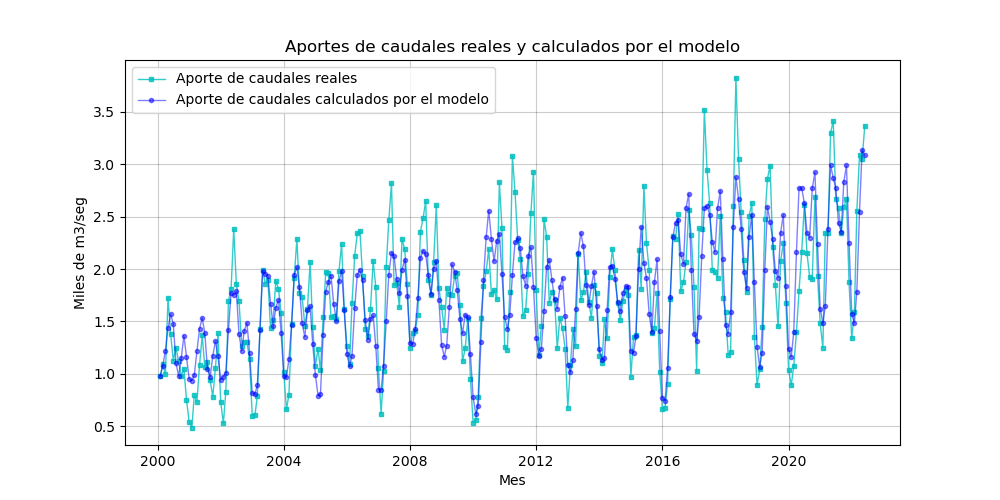

In [15]:
#*******************************************************************************
# 4.4.5. Grafica aporte de caudales reales y ajustados.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales reales y calculados por el modelo')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(caudal_mei.index, caudal_mei.aporCaudalRio, 'c-s', \
    label='Aporte de caudales reales', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
    label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
# plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

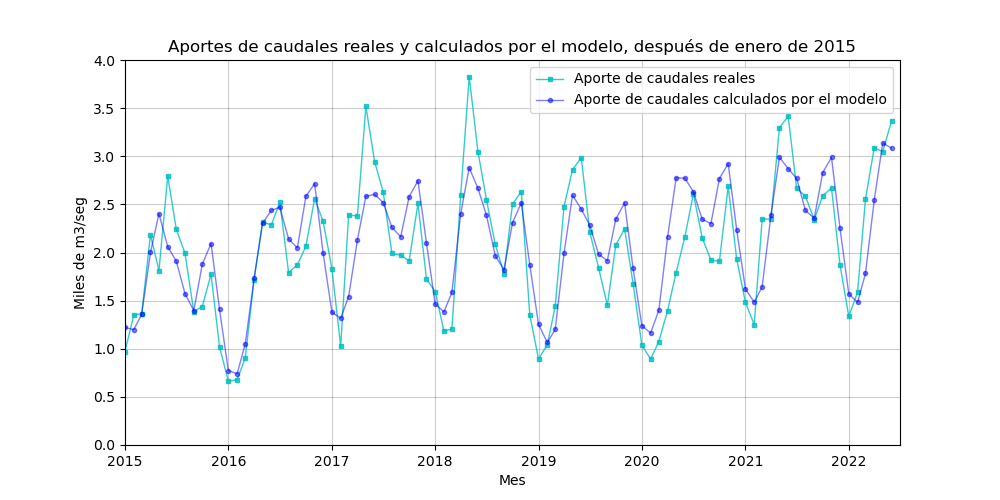

In [16]:
#*******************************************************************************
# 4.4.6. Grafica aporte de caudales reales y ajustados, después de 2015.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales reales y calculados por el modelo, después de enero de 2015')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(caudal_mei.index, caudal_mei.aporCaudalRio, 'c-s', \
    label='Aporte de caudales reales', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
    label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [140]:
#*******************************************************************************
# 4.4.7. Define el mape.
#*******************************************************************************
#mean_absolute_percentage_error, La media del porcentaje de error absoluto. 
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
#*******************************************************************************
# 4.4.8. Aplica el mape a todo el conjunto de datos.
#*******************************************************************************
mape(caudal_mei.aporCaudalRio, caudal_mei.aporCaudal_hat) #16.38%.

16.38407717086482

In [35]:
#*******************************************************************************
# 4.4.9. Crea caudal_mei_m (para modelo) subconjuntos de train y test.
#*******************************************************************************
caudal_mei_m = caudal_mei.drop(columns=['mei1', 'aporCaudal_hat'], axis=1)

In [37]:
#*******************************************************************************
# 4.4.10. Salva  y lee caudal_mei_m (para el modelo con train y test).
#*******************************************************************************
#Salva caudal_mei_m
# caudal_mei_m.to_parquet('parquet/caudal_mei_m.parquet.gzip', \
#     compression='gzip', engine='fastparquet')
#Lee caudal_mei_m
caudal_mei_m = pd.read_parquet('parquet/caudal_mei_m.parquet.gzip', \
    engine='fastparquet')

In [39]:
#*******************************************************************************
# 4.4.11. Crea subconjuntos de train y test.
#*******************************************************************************
caudal_mei_m = caudal_mei.drop(columns=['aporCaudal_hat'], axis=1)
train = caudal_mei_m.iloc[:-78]
test = caudal_mei_m.iloc[-78:]

In [41]:
#*******************************************************************************
# 4.4.12. Modelo de regresión lineal aplicado a train.
#*******************************************************************************
regresion_lineal = smf.ols(formula = 'aporCaudalRio ~ mei + aporCaudalMediHistRio', data=train)
modelo_ajustado_caudal_t = regresion_lineal.fit()
modelo_ajustado_caudal_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          aporCaudalRio   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     187.4
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           1.70e-45
Time:                        17:29:20   Log-Likelihood:                -45.545
No. Observations:                 191   AIC:                             97.09
Df Residuals:                     188   BIC:                             106.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0310      0.089     -0.349      0.728      -0.206       0.144
mei                      -0.2641      0.027     -9.802      0.000      -0.317      -0.211
aporCaudalMediHistRio     0.9556      0.052     18.477      0.000       0.854       1.058
==============================================================================
Omnibus:                       13.811   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.377
Skew:                           0.572   Prob(JB):                     0.000458
Kurtosis:                       3.789   Cond. No.                         8.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
#*******************************************************************************
# 4.4.13. Salva  y lee el modelo_ajustado_caudal_t (aplicado a train)
#*******************************************************************************
#Salva modelo_ajustado_caudal_t
# modelo_ajustado_caudal_t.save('modelos/modelo_ajustado_caudal_t.pickle')
#Lee modelo_ajustado_caudal
modelo_ajustado_caudal_t = sm.load('modelos/modelo_ajustado_caudal_t.pickle')

In [43]:
#*******************************************************************************
# 4.4.14. Incluye los valores ajustados de test.
#*******************************************************************************
valores_ajustados = modelo_ajustado_caudal_t.predict(test)
test.insert(loc=3, column='aporCaudal_hat', value=valores_ajustados, allow_duplicates=True)

In [44]:
#*******************************************************************************
# 4.4.15. Calcula el modelo en test.
#*******************************************************************************
mape(test.aporCaudalRio, test.aporCaudal_hat) #16.5%

16.548927941040834

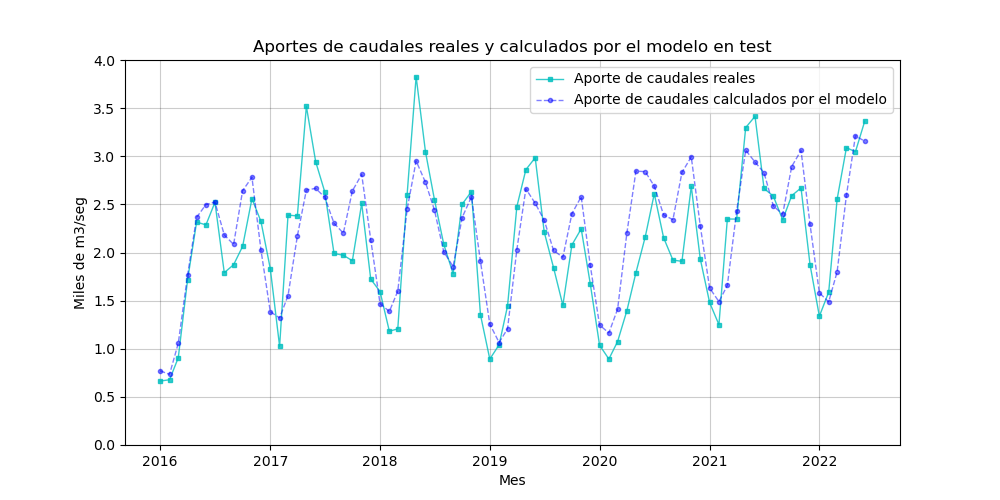

In [45]:
#*******************************************************************************
# 4.4.16. Grafica aporte de caudales reales y calculados por el modelo en test.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales reales y calculados por el modelo en test')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(test.index, test.aporCaudalRio, 'c-s', \
    label='Aporte de caudales reales', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(test.index, test.aporCaudal_hat, 'b--o', \
    label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.5. Proyección de los 'Aportes de caudales de lluvia históricos' 

In [2]:
#*******************************************************************************
# 4.5.1. Lee aportes_m.
#*******************************************************************************
#Lee aportes_m
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

In [3]:
#*******************************************************************************
# 4.5.2. Crea aportes_h (históricos).
#*******************************************************************************
aportes_h = aportes_m
aportes_h = aportes_h.drop(columns=['aporEner', 'aporEnerMediHist', 'aporCaudalRio', \
    'diferenciaAportes'], axis=1)
aportes_h['aporCaudalMediHistRio'] = aportes_h['aporCaudalMediHistRio']/1e3 

In [5]:
#*******************************************************************************
# 4.5.3. Corrige valores atípicos de aporCaudalMediHistRio.
#*******************************************************************************
# aportes_h.loc[pd.to_datetime('2013-05-01'), 'aporCaudalMediHistRio'] #3.41
# aportes_h.loc[pd.to_datetime('2015-10-01'), 'aporCaudalMediHistRio'] #5.20
# aportes_h.loc[pd.to_datetime('2015-11-01'), 'aporCaudalMediHistRio'] #5.29
# aportes_h.loc[pd.to_datetime('2015-12-01'), 'aporCaudalMediHistRio'] #4.07
#
# aportes_h.loc[pd.to_datetime('2014-05-01'), 'aporCaudalMediHistRio'] #2.13
# aportes_h.loc[pd.to_datetime('2016-10-01'), 'aporCaudalMediHistRio'] #2.63
# aportes_h.loc[pd.to_datetime('2016-11-01'), 'aporCaudalMediHistRio'] #2.80
# aportes_h.loc[pd.to_datetime('2016-12-01'), 'aporCaudalMediHistRio'] #2.05
#
aportes_h_c = aportes_h.copy()
aportes_h_c.loc['2013-05-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2014-05-01', 'aporCaudalMediHistRio']
aportes_h_c.loc['2015-10-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2016-10-01', 'aporCaudalMediHistRio']
aportes_h_c.loc['2015-11-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2016-11-01', 'aporCaudalMediHistRio']
aportes_h_c.loc['2015-12-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2016-12-01', 'aporCaudalMediHistRio']
aportes_h = aportes_h_c  

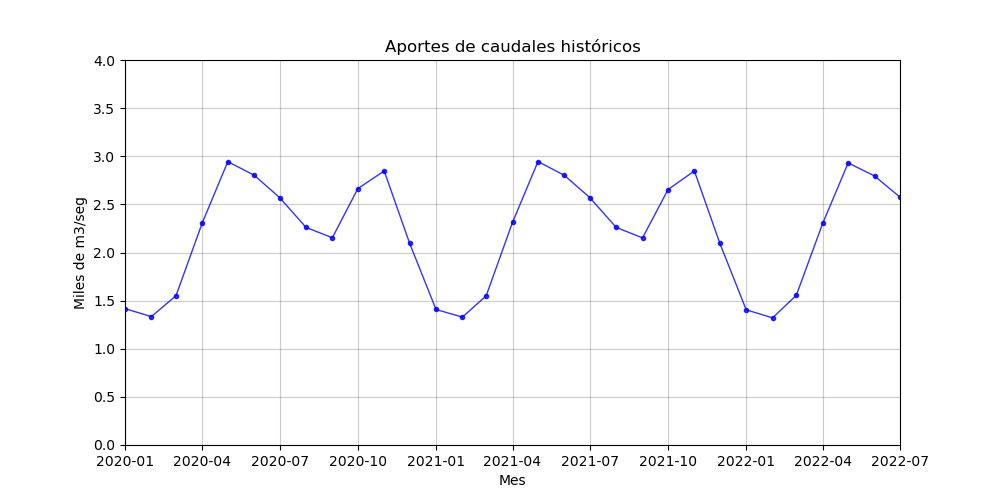

In [6]:
#*******************************************************************************
# 4.5.4. Grafica de aporte de caudales históricos.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales históricos')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_h.index, aportes_h.aporCaudalMediHistRio, 'b-o', \
    label='Aporte de caudales históricos', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
#     label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [7]:
#*******************************************************************************
# 4.5.5. Crea los aportes futuros de caudales históricos.
#*******************************************************************************
aportes_repetidos = pd.DataFrame(aportes_h.loc['2021-07-01': '2022-06-01', \
    'aporCaudalMediHistRio'].values, index=range(0,12))
aportes_futuros = pd.DataFrame()
for i in range(1, 7):
    aportes_futuros = aportes_futuros.append(aportes_repetidos)
aportes_futuros = aportes_futuros.append(aportes_repetidos[0:6])
aportes_futuros = aportes_futuros.reset_index()
aportes_futuros = aportes_futuros.drop(columns=['index'], axis=1)


In [11]:
#*******************************************************************************
# 4.5.6. Crea DataFrame de proyección.
#*******************************************************************************
aportes_h_py = pd.DataFrame({'aporCaudalMediHistRio': \
    aportes_futuros[0].values}, index=pd.date_range(start='2022-07-01', \
        periods = 78, freq='MS'))
aportes_h_py.index.name = 'Date'


In [16]:
#*******************************************************************************
# 4.5.7. Integra DataFrame de proyección con aportes históricos.
#*******************************************************************************
aportes_h_py = aportes_h_py.rename(columns={'aporCaudalMediHistRio': \
    'aporCaudalHistProy'})
aportes_h = aportes_h.join(aportes_h_py, how='outer')


In [29]:
#*******************************************************************************
# 4.5.8. Salva  y lee aportes_h.
#*******************************************************************************
#Salva aportes_h
# aportes_h.to_parquet('parquet/aportes_h.parquet.gzip', \
#     compression='gzip', engine='fastparquet')
#Lee caudal_mei_m
aportes_h = pd.read_parquet('parquet/aportes_h.parquet.gzip', \
    engine='fastparquet')

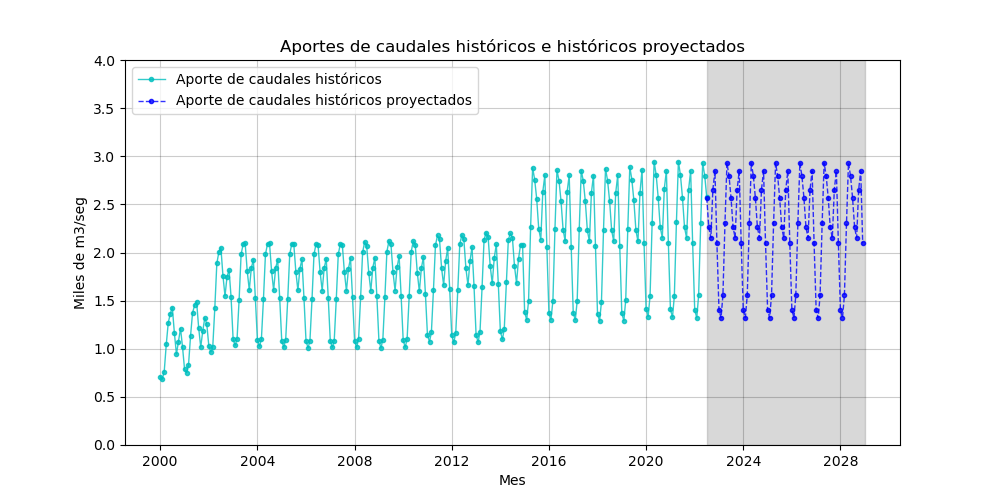

In [30]:
#*******************************************************************************
# 4.5.9. Grafica de aporte de caudales históricos e históricos proyectados.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales históricos e históricos proyectados')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_h.index, aportes_h.aporCaudalMediHistRio, 'c-o', \
    label='Aporte de caudales históricos', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_h.index, aportes_h.aporCaudalHistProy, 'b--o', \
    label='Aporte de caudales históricos proyectados', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
#     label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

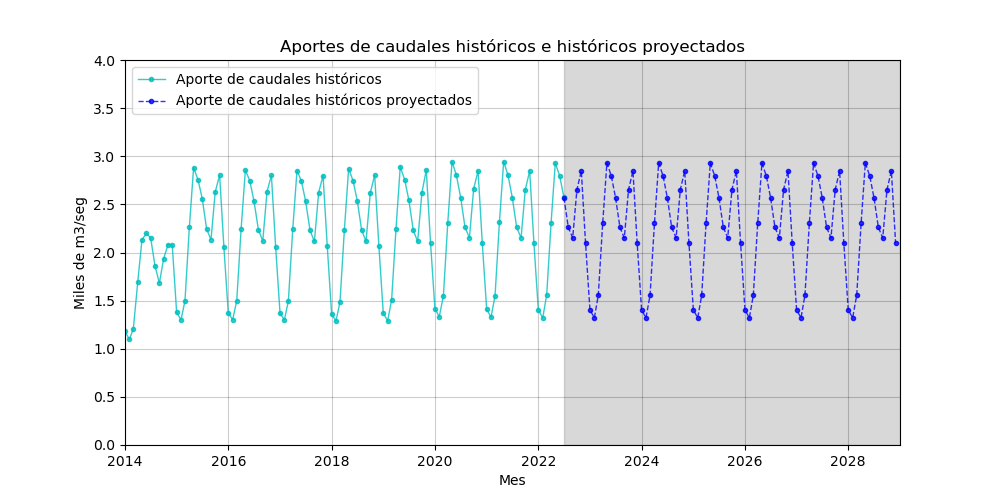

In [27]:
#*******************************************************************************
# 4.5.10. Grafica de caudales históricos y proyectados, desde 2014.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales históricos e históricos proyectados')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_h.index, aportes_h.aporCaudalMediHistRio, 'c-o', \
    label='Aporte de caudales históricos', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_h.index, aportes_h.aporCaudalHistProy, 'b--o', \
    label='Aporte de caudales históricos proyectados', linewidth=1, \
        markersize=3, alpha=0.8)
# ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
#     label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.6. Proyección de los 'Aportes de caudales de lluvias'
La proyección de los aportes de caudales de lluvias se deben hacer para tres escenarios hasta diciembre de 2028.

La variable objetivo es 'aporCaudalRio' y las variables explicativas son: 'mei' y 'aporCaudalMediHistRio'.

La variable 'mei' es la que genera los tres escenarios.

Ya se cuenta con el modelo y se requiera elaborar el nuevo conjunto de datos sobre los que se aplicará la proyección.

In [28]:
#*******************************************************************************
# 4.6.1. Se carga el modelo_ajustado_caudal basado en el conjunto 'train'.
#*******************************************************************************
modelo_ajustado_caudal_t = sm.load('modelos/modelo_ajustado_caudal_t.pickle')

In [163]:
#*******************************************************************************
# 4.6.2. Se leen las variables requeridas para proyectar los aportes de lluvias.
#*******************************************************************************
#Lee el meiT que contiene las proyecciones de mei en tres escenarios.
meiT = pd.read_parquet('parquet/meiT.parquet.gzip', \
    engine='fastparquet')
#Lee el aportes_h que contiene las proyecciones aportes históricos proyectados.
aportes_h = pd.read_parquet('parquet/aportes_h.parquet.gzip', \
    engine='fastparquet')
#Lee el caudal_mei_m que contiene el formato para aplicar al modelo.
caudal_mei_m = pd.read_parquet('parquet/caudal_mei_m.parquet.gzip', \
    engine='fastparquet')



In [164]:
#*******************************************************************************
# 4.6.3. Crea tres escenarios de caudal_mei para proyectar aportes de lluvias.
#*******************************************************************************
aportes_h = aportes_h.drop(columns=['aporCaudalMediHistRio'], axis=1)
caudal_mei_m0 = caudal_mei_m.join(aportes_h, how='right')
caudal_mei_m0['aporCaudalMediHistRio'] = caudal_mei_m0['aporCaudalHistProy']
caudal_mei_m0 = caudal_mei_m0.loc[pd.to_datetime('2022-07-01'):pd.to_datetime('2028-12-01'), \
    ['aporCaudalRio', 'mei', 'aporCaudalMediHistRio']]
meiT = meiT.loc[pd.to_datetime('2022-07-01'):pd.to_datetime('2028-12-01'), \
     ['meiP1988_08', 'meiP1998_08', 'meiP2010_07']]
meiT = meiT.rename(columns={'meiP1988_08': 'EscenarioAlto', \
    'meiP1998_08': 'EscenarioBajo', 'meiP2010_07': 'EscenarioMedio'})
#
caudal_mei_Alto = caudal_mei_m0.copy()
caudal_mei_Medio = caudal_mei_m0.copy()
caudal_mei_Bajo = caudal_mei_m0.copy()
#
caudal_mei_Alto['mei'] = meiT['EscenarioAlto'].values
caudal_mei_Medio['mei'] = meiT['EscenarioMedio'].values
caudal_mei_Bajo['mei'] = meiT['EscenarioBajo'].values


In [186]:
#*******************************************************************************
# 4.6.4. Calcula los valores proyectados en los tres escenarios.
#*******************************************************************************
# valores_ajustados_Alto = modelo_ajustado_caudal_t.predict(caudal_mei_Alto)
# caudal_mei_Alto['aporCaudalRio'] = valores_ajustados_Alto
# caudal_mei_Alto = caudal_mei_Alto.rename(columns={'aporCaudalRio': \
#     'aporCaudalAlto'})

# valores_ajustados_Medio = modelo_ajustado_caudal_t.predict(caudal_mei_Medio)
# caudal_mei_Medio['aporCaudalRio'] = valores_ajustados_Medio
# caudal_mei_Medio = caudal_mei_Medio.rename(columns={'aporCaudalRio': \
#     'aporCaudalMedio'})

# valores_ajustados_Bajo = modelo_ajustado_caudal_t.predict(caudal_mei_Bajo)
# caudal_mei_Bajo['aporCaudalRio'] = valores_ajustados_Bajo
# caudal_mei_Bajo = caudal_mei_Bajo.rename(columns={'aporCaudalRio': \
#     'aporCaudalBajo'})

# caudal_escenarios = caudal_mei_Alto.copy()
# caudal_escenarios = caudal_escenarios.drop(columns=['mei', 'aporCaudalMediHistRio'], axis=1)
# caudal_escenarios.insert(loc=1, column='aporCaudalMedio', \
#     value=caudal_mei_Medio.loc[:, 'aporCaudalMedio'].values)
# caudal_escenarios.insert(loc=2, column='aporCaudalBajo', \
#     value=caudal_mei_Bajo.loc[:, 'aporCaudalBajo'].values)

# caudal_escenarios

In [188]:
#*******************************************************************************
# 4.6.5. Salva  y lee caudal_escenarios.
#*******************************************************************************
#Salva caudal_escenarios
caudal_escenarios.to_parquet('parquet/caudal_escenarios.parquet.gzip', \
    compression='gzip', engine='fastparquet')
#Lee caudal_escenarios
caudal_escenarios = pd.read_parquet('parquet/caudal_escenarios.parquet.gzip', \
    engine='fastparquet')

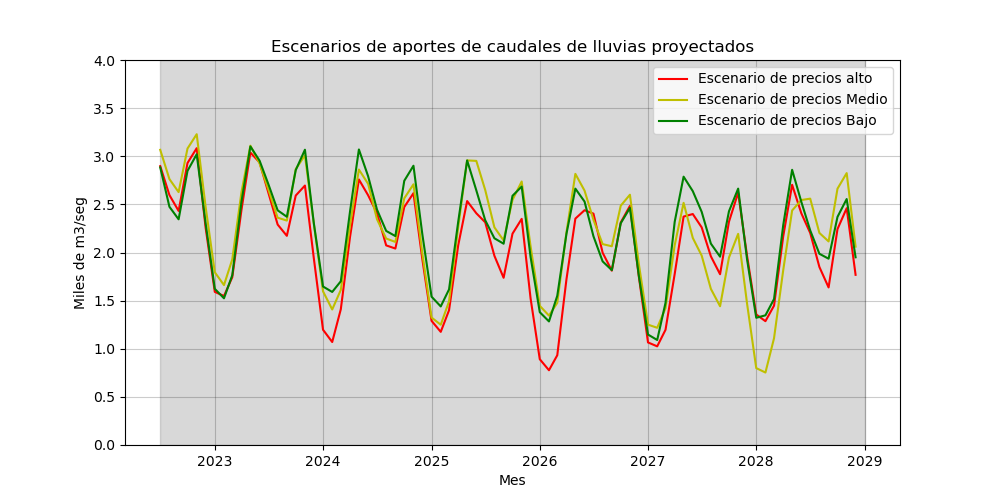

In [190]:
#*******************************************************************************
# 4.6.6. Grafica de caudales de lluvias proyectados, en tres escenarios.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Escenarios de aportes de caudales de lluvias proyectados')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(caudal_escenarios.index, caudal_escenarios.aporCaudalAlto, 'r-', \
    label='Escenario de precios alto', markersize=2)
ax1.plot(caudal_escenarios.index, caudal_escenarios.aporCaudalMedio, 'y-', \
    label='Escenario de precios Medio', markersize=2)
ax1.plot(caudal_escenarios.index, caudal_escenarios.aporCaudalBajo, 'g-', \
    label='Escenario de precios Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.7. Proyección de los 'Aportes de lluvias en energía'
Ya se cuenta con el factor de conversión y es aporEner = (aporCaudalRio * 0.0857) - 5.799

In [217]:
#*******************************************************************************
# 4.7.1. Crea aporte_energia_escenarios, en tres escenarios.
#*******************************************************************************
aporte_energia_escenarios = caudal_escenarios.copy()

aporte_energia_escenarios.insert(loc=3, column='aporteEnergiaAlto', \
    value=(aporte_energia_escenarios.aporCaudalAlto * 1e3 * 0.0857) - 5.799, \
        allow_duplicates=True)

aporte_energia_escenarios.insert(loc=4, column='aporteEnergiaMedio', \
    value=(aporte_energia_escenarios.aporCaudalMedio * 1e3 * 0.0857) - 5.799, \
        allow_duplicates=True)

aporte_energia_escenarios.insert(loc=5, column='aporteEnergiaBajo', \
    value=(aporte_energia_escenarios.aporCaudalBajo * 1e3 * 0.0857) - 5.799, \
        allow_duplicates=True)

In [220]:
#*******************************************************************************
# 4.7.2. Solo deja escenarios de aporte_energia, elimina caudales.
#*******************************************************************************
aporte_energia_escenarios = aporte_energia_escenarios.drop(columns=['aporCaudalAlto', 'aporCaudalMedio', \
    'aporCaudalBajo'], axis=1)

In [222]:
#*******************************************************************************
# 4.7.3. Salva  y lee aporte_energia_escenarios.
#*******************************************************************************
#Salva aporte_energia_escenarios
# aporte_energia_escenarios.to_parquet\
#     ('parquet/aporte_energia_escenarios.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee aporte_energia_escenarios
aporte_energia_escenarios = pd.read_parquet\
    ('parquet/aporte_energia_escenarios.parquet.gzip', engine='fastparquet')

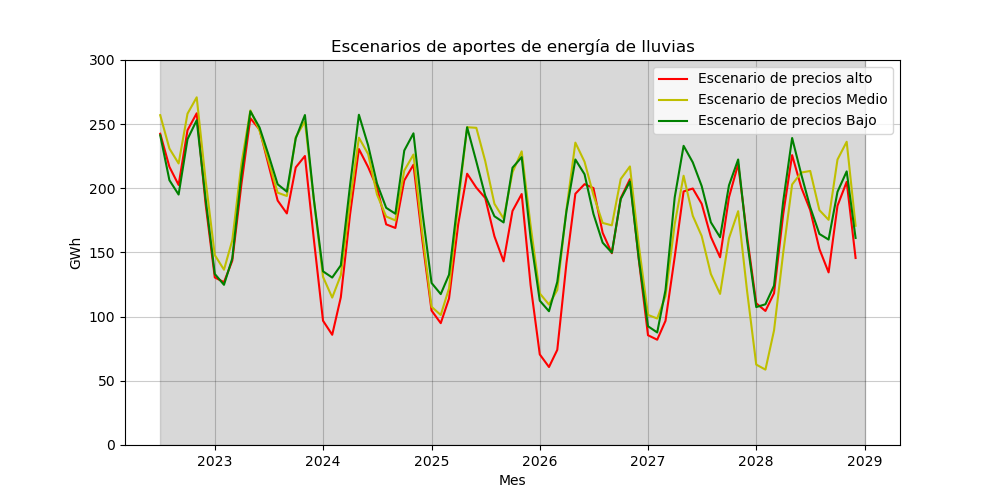

In [225]:
#*******************************************************************************
# 4.7.4. Grafica los aportes de energía de lluvias en tres escenarios.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Escenarios de aportes de energía de lluvias')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
    label='Escenario de precios alto', markersize=2)
ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
    label='Escenario de precios Medio', markersize=2)
ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
    label='Escenario de precios Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 300)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.8. Proyección de los Precios de Bolsa Mensuales (Pbm)
Los Pbm a proyectar tendrán las siguientes condiciones:
1. Serán los precios sin Cee. Al final, a los precios proyectados se les debe agregar el Cee.
2. Serán los logaritmos de los precios (pbm_log). Esto con el fin de garantizar que los precios sean siempre positivos y que el rango de los precios no sean tan amplios. Al final los precios se deben convertir con la fórmula EXP(pbm_log).

### 4.8.1. Creación del Pbm_log

In [137]:
#*******************************************************************************
# 4.8.1. Se leen pbm y cee.
#*******************************************************************************
#Lee pbm.
pbm = pd.read_parquet('parquet/pbm.parquet.gzip', engine='fastparquet') #271, se debe quitar 2022-07.
#Lee cee_cere.
cee_cere = pd.read_parquet('parquet/cee_cere.parquet.gzip', \
    engine='fastparquet')
#Lee cee_cere2014_07.
cee_cere2014_07 = pd.read_parquet('parquet/cee_cere2014_07.parquet.gzip', \
    engine='fastparquet') #270 filas.

In [138]:
#*******************************************************************************
# 4.8.2. Se integra el cee al pbm.
#*******************************************************************************
#Se crea pbm_cee y se ajusta el nombre de índice, se eliminan columnas y fila.
pbm_cee = pbm.copy()
pbm_cee.index.name = 'Date'
pbm_cee = pbm_cee.drop(columns=['preEsca', 'preConEsca'], axis=1)
pbm_cee = pbm_cee.drop(index=pd.to_datetime('2022-07-01'), axis=0)

#Se integran las columna de pbm y cee.
pbm_cee = pbm_cee.join(cee_cere, how='inner')

#Se crea pbm_log
pbm_cee.insert(loc=len(pbm_cee.columns), column='pbm_log', \
    value=np.log(pbm_cee.precio), allow_duplicates=True)

#Se resta cee a precio y se obtiene pbm_sc (pbm sin cee).
pbm_cee.insert(loc=len(pbm_cee.columns), column='pbm_sc', value=pbm_cee.precio - pbm_cee.cee, \
    allow_duplicates=True)
#Se aplica el logaritmo pbm_sc y se obtiene pbm_sc_log.
pbm_cee.insert(loc=len(pbm_cee.columns), column='pbm_sc_log', value=np.log(pbm_cee.pbm_sc), \
    allow_duplicates=True)


In [140]:
#*******************************************************************************
# 4.8.3. Salva  y lee pbm_cee.
#*******************************************************************************
#Salva pbm_cee
# pbm_cee.to_parquet\
#     ('parquet/pbm_cee.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee pbm_cee
pbm_cee = pd.read_parquet\
    ('parquet/pbm_cee.parquet.gzip', engine='fastparquet')

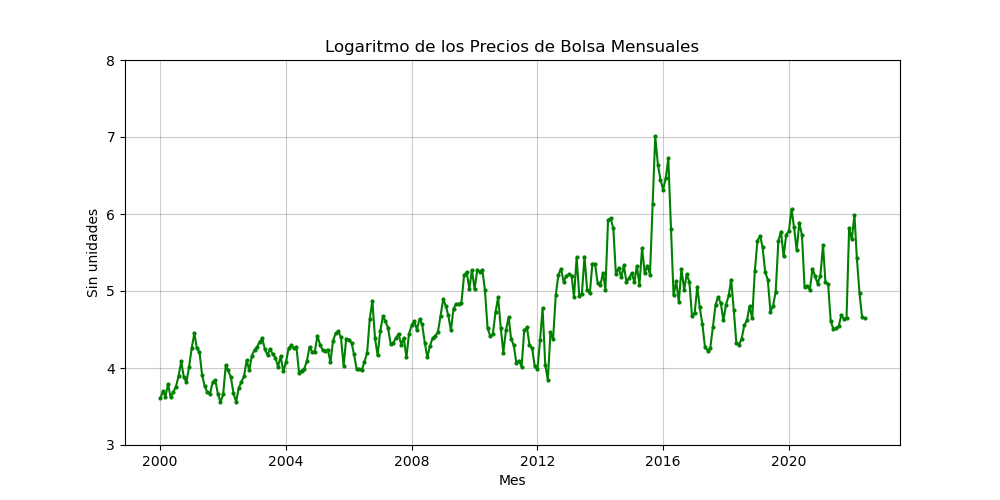

In [143]:
#*******************************************************************************
# 4.8.4. Grafica pbm_log.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Logaritmo de los Precios de Bolsa Mensuales')
ax1.set_ylabel ('Sin unidades')
ax1.set_xlabel ('Mes')
ax1.plot(pbm_cee.index, pbm_cee.pbm_log, 'g-o', \
    label='Logaritmo de Pbm', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(3, 8)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

### 4.8.2. Creación del modelo de predicción de pbm_log
Se explorarán diferentes variables que pueden influenciar o explicar los precios de energía en bolsa:
1. Aportes de lluvias en energía.
2. Diferencia entre los aportes de lluvia en energía y los aportes históricos de lluvias en energía (expectativas).
3. Capacidad de generación instalada.
4. Demanda de energía.

#### 4.8.2.1. Adquiere 'aportes de lluvia en energía' y 'diferencia de aportes de lluvia'

In [144]:
#*******************************************************************************
# 4.8.5. Lee aportes_m.
#*******************************************************************************
#Lee aportes_m
aportes_m = pd.read_parquet\
    ('parquet/aportes_m.parquet.gzip', engine='fastparquet')

In [145]:
#*******************************************************************************
# 4.8.6. Ajusta aportes_m, elimina columnas y fila. Se integra con pbm_cee. 
#*******************************************************************************
aportes_m = aportes_m.drop(columns=['aporCaudalRio', 'aporCaudalMediHistRio'], \
    axis=1)
aportes_m = aportes_m.drop(index=pd.to_datetime('2022-07-01'), axis=0)
#Se integran las columna de pbm y cee.
pbm_cee = pbm_cee.join(aportes_m, how='inner') #Con aportes de energía.
pbm_cee_a = pbm_cee.copy() #Con aportes de energía.

In [147]:
#*******************************************************************************
# 4.8.7. Salva  y lee pbm_cee_a.
#*******************************************************************************
# #Salva pbm_cee_a
# pbm_cee_a.to_parquet\
#     ('parquet/pbm_cee_a.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee pbm_cee_a
pbm_cee_a = pd.read_parquet\
    ('parquet/pbm_cee_a.parquet.gzip', engine='fastparquet')

#### 4.8.2.2. Adquiere las variables 'capacidad de generación' y 'demanda'

In [148]:
#*******************************************************************************       
# 4.8.8. Crea la máquina para conectarse a la base de datos dbXm.db.
#*******************************************************************************
engine = create_engine('sqlite:///dbXm.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()

In [149]:
#*******************************************************************************       
# 4.8.9. Lee las variables de 'capacidades' y 'demanda' diarias.
#*******************************************************************************
tablas = ['CapaUtilDiarEner', 'DemaSin']
nombresDf = ['capaUtilDiarEner', 'demaSin']
df = {}

for i, tabla in  enumerate(tablas):
    consulta = "SELECT * FROM " + tabla
    df[nombresDf[i]] = pd.read_sql(consulta, engine, parse_dates=["Date"])
#Ajusta las columnas, los índices y los nombres de los DataFrames.
for i, nombre in  enumerate(nombresDf):
   df[nombre] = df[nombre].iloc[:, 1:] if i <= 1 else df[nombre].iloc[:, [1, 3]]
   df[nombre] = df[nombre].set_index('Date')
   df[nombre].columns = [nombre]

In [150]:
#*******************************************************************************       
# 4.8.10. Convierte 'capacidades' y 'demandas' diarias a promedio mensuales.
#*******************************************************************************
capacidad_m = df['capaUtilDiarEner']
capacidad_m = capacidad_m.groupby(capacidad_m.index.to_period('M')).mean()
capacidad_m.index = capacidad_m.index.to_timestamp()
capacidad_m = capacidad_m.drop(index=pd.to_datetime('2022-07-01'), axis=0)
capacidad_m = capacidad_m.rename(columns={'capaUtilDiarEner':'capacidad'})
capacidad_m.capacidad = capacidad_m.capacidad/1e9 #TWh

demanda_m = df['demaSin']
demanda_m = demanda_m.groupby(demanda_m.index.to_period('M')).mean()
demanda_m.index = demanda_m.index.to_timestamp()
demanda_m = demanda_m.drop(index=pd.to_datetime('2022-07-01'), axis=0)
demanda_m = demanda_m.rename(columns={'demaSin':'demanda'})
demanda_m.demanda = demanda_m.demanda/1e9 #TWh

In [151]:
#*******************************************************************************       
# 4.8.11. Salva 'capacidad_m' y 'demanda_m', son promedio mensuales en TWh.
#*******************************************************************************
# #Salva capacidad_m
# capacidad_m.to_parquet\
#     ('parquet/capacidad_m.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
# #Salva demanda_m
# demanda_m.to_parquet\
#     ('parquet/demanda_m.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee capacidad_m
capacidad_m = pd.read_parquet\
    ('parquet/capacidad_m.parquet.gzip', engine='fastparquet')
#Lee demanda_m
demanda_m = pd.read_parquet\
    ('parquet/demanda_m.parquet.gzip', engine='fastparquet')

In [158]:
#*******************************************************************************       
# 4.8.12. Integra 'capacidades' y 'demandas' mensuales a pbm_cee_a.
#*******************************************************************************
#Lee pbm_cee_a
pbm_cee_a = pd.read_parquet\
    ('parquet/pbm_cee_a.parquet.gzip', engine='fastparquet')
#Convierte aportes a TWh.
pbm_cee_a['aporEner'] = pbm_cee_a['aporEner']/1e3 
pbm_cee_a['aporEnerMediHist'] = pbm_cee_a['aporEnerMediHist']/1e3 
pbm_cee_a['diferenciaAportes'] = pbm_cee_a['diferenciaAportes']/1e3 

pbm_cee_a = pbm_cee_a.join(capacidad_m, how='inner')
pbm_cee_a = pbm_cee_a.join(demanda_m, how='inner')
pbm_cee_acd = pbm_cee_a.copy() #pbm con acd: aportesEnergia, capacidad, demanda.


In [92]:
#*******************************************************************************       
# 4.8.13. Salva y lee pbm_cee_acd.
#*******************************************************************************
# #Salva pbm_cee_acd
# pbm_cee_acd.to_parquet\
#     ('parquet/pbm_cee_acd.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee pbm_cee_acd
pbm_cee_acd = pd.read_parquet\
    ('parquet/pbm_cee_acd.parquet.gzip', engine='fastparquet')

#### 4.8.2.3. Elabora el modelo de regresión del objetivo pbm_sc_log.

In [134]:
#*******************************************************************************
# 4.8.14. Crea subconjuntos de train y test.
#*******************************************************************************
train = pbm_cee_acd.iloc[:-30]
test = pbm_cee_acd.iloc[-30:]

In [135]:
#*******************************************************************************
# 4.8.15. Matriz de correlación.
#*******************************************************************************
corr = test.iloc[:, [3, 6, 7, 8, 9, 10]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [136]:
#*******************************************************************************
# 4.8.16. Modelo de regresión lineal aplicado a train.
#*******************************************************************************
regresion_lineal = smf.ols(formula = 'pbm_log ~ aporEner + \
    aporEnerMediHist + capacidad + demanda', data=train)
modelo_ajustado_pbm_acd = regresion_lineal.fit()
modelo_ajustado_pbm_acd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pbm_log   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     147.0
Date:                Sat, 13 Aug 2022   Prob (F-statistic):           9.22e-63
Time:                        15:46:17   Log-Likelihood:                -79.724
No. Observations:                 240   AIC:                             169.4
Df Residuals:                     235   BIC:                             186.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.0681      0.389      7.878      0.000       2.301       3.835
aporEner            -5.9763      0.616     -9.694      0.000      -7.191      -4.762
aporEnerMediHist     2.8967      0.800      3.621      0.000       1.321       4.473
capacidad           -0.0948      0.030     -3.130      0.002      -0.154      -0.035
demanda             22.5465      1.204     18.726      0.000      20.174      24.918
==============================================================================
Omnibus:                       32.845   Durbin-Watson:                   0.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.811
Skew:                           0.627   Prob(JB):                     7.70e-18
Kurtosis:                       5.511   Cond. No.                         890.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
#*******************************************************************************
# 4.8.17. Salva  y lee el modelo_ajustado_pbm_acd (aplicado a train)
#*******************************************************************************
# #Salva modelo_ajustado_pbm_acd
# modelo_ajustado_pbm_acd.save('modelos/modelo_ajustado_pbm_acd.pickle')
#Lee modelo_ajustado_caudal
modelo_ajustado_pbm_acd = sm.load('modelos/modelo_ajustado_pbm_acd.pickle')

In [138]:
#*******************************************************************************
# 4.8.18. Incluye los valores ajustados de train.
#*******************************************************************************
valores_ajustados = modelo_ajustado_pbm_acd.predict(train)
train.insert(loc=len(train.columns), column='pbm_log_hat', \
    value=valores_ajustados, allow_duplicates=True)

In [141]:
#*******************************************************************************
# 4.8.19. Calcula el error del modelo en train.
#*******************************************************************************
mape(train.pbm_log, train.pbm_log_hat) #5%

5.08715198194615

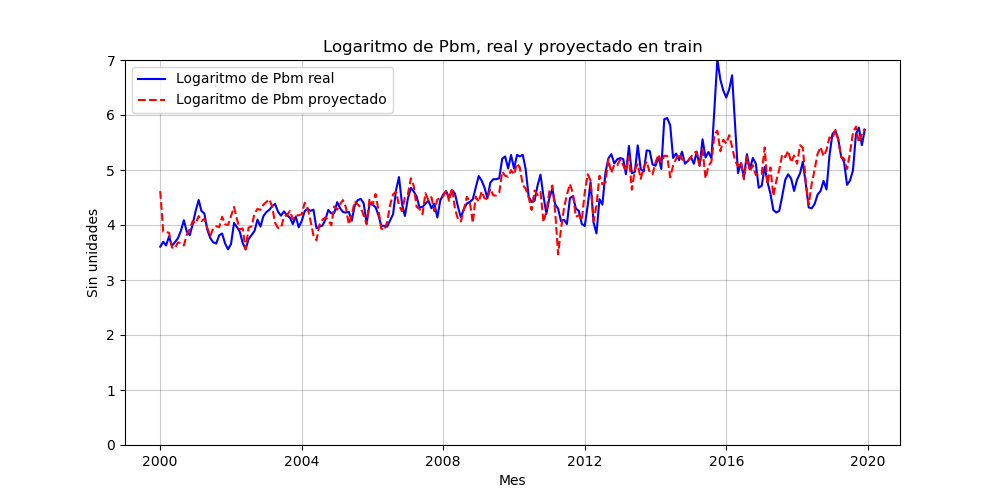

In [169]:
#*******************************************************************************
# 4.8.20. Grafica pbm_log real y proyectado en train.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Logaritmo de Pbm, real y proyectado en train')
ax1.set_ylabel ('Sin unidades')
ax1.set_xlabel ('Mes')
ax1.plot(train.index, train.pbm_log, 'b-', \
    label='Logaritmo de Pbm real', markersize=2)
ax1.plot(train.index, train.pbm_log_hat, 'r--', \
    label='Logaritmo de Pbm proyectado', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 7)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [142]:
#*******************************************************************************
# 4.8.21. Incluye los valores de pbm convertidos a train.
#*******************************************************************************
pbm_convertidos = np.exp(train.pbm_log_hat)
train.insert(loc=len(train.columns), column='pbm_hat', value=pbm_convertidos, allow_duplicates=True)

In [143]:
#*******************************************************************************
# 4.8.22. Calcula el error del modelo en train sobre pbm.
#*******************************************************************************
mape(train.precio, train.pbm_hat) #24%

24.45581294936937

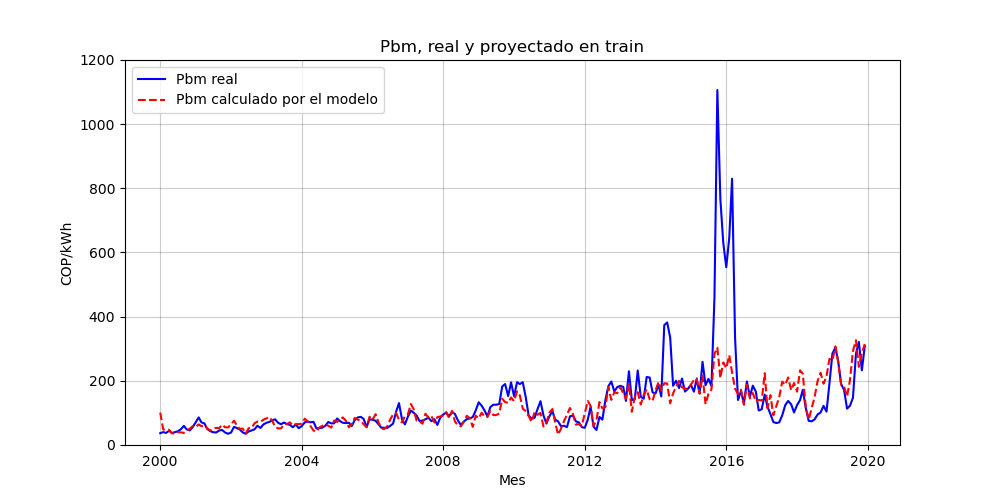

In [144]:
#*******************************************************************************
# 4.8.23. Grafica pbm real y proyectado en train.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Pbm, real y proyectado en train')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(train.index, train.precio, 'b-', \
    label='Pbm real', markersize=2)
ax1.plot(train.index, train.pbm_hat, 'r--', \
    label='Pbm calculado por el modelo', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 1200)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [145]:
#*******************************************************************************
# 4.8.24. Incluye los valores ajustados de test.
#*******************************************************************************
valores_ajustados = modelo_ajustado_pbm_acd.predict(test)
test.insert(loc=len(test.columns), column='pbm_log_hat', value=valores_ajustados, allow_duplicates=True)

In [146]:
#*******************************************************************************
# 4.8.25. Calcula el error del modelo en test.
#*******************************************************************************
mape(test.pbm_log, test.pbm_log_hat) #7%

7.2749077007968355

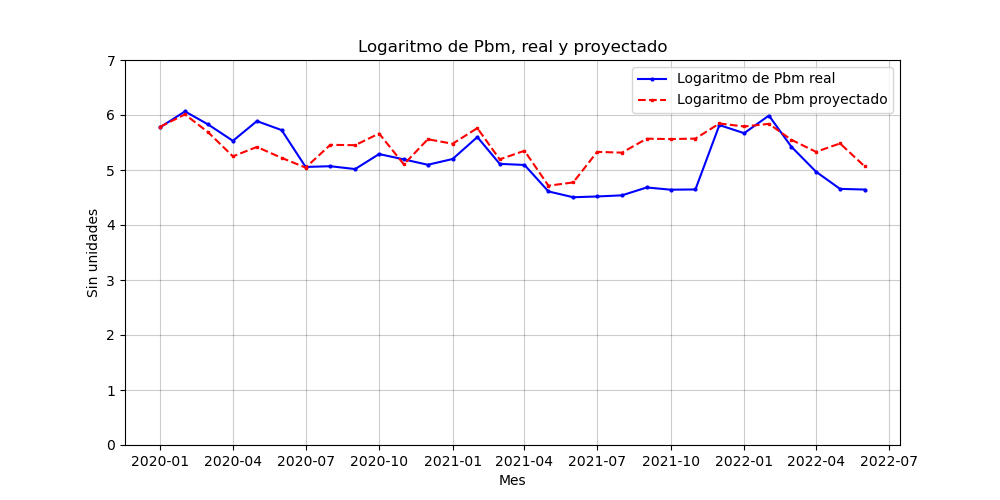

In [184]:
#*******************************************************************************
# 4.8.26. Grafica pbm_log real y proyectado en test.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Logaritmo de Pbm, real y proyectado')
ax1.set_ylabel ('Sin unidades')
ax1.set_xlabel ('Mes')
ax1.plot(test.index, test.pbm_log, 'b-o', \
    label='Logaritmo de Pbm real', markersize=2)
ax1.plot(test.index, test.pbm_log_hat, 'r--s', \
    label='Logaritmo de Pbm proyectado', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 7)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [147]:
#*******************************************************************************
# 4.8.27. Incluye los valores de pbm convertidos a test.
#*******************************************************************************
pbm_convertidos = np.exp(test.pbm_log_hat)
test.insert(loc=len(test.columns), column='pbm_hat', value=pbm_convertidos, allow_duplicates=True)

In [148]:
#*******************************************************************************
# 4.8.28. Calcula el error del modelo en test sobre pbm.
#*******************************************************************************
mape(test.precio, test.pbm_hat) #47%

47.411488340293204

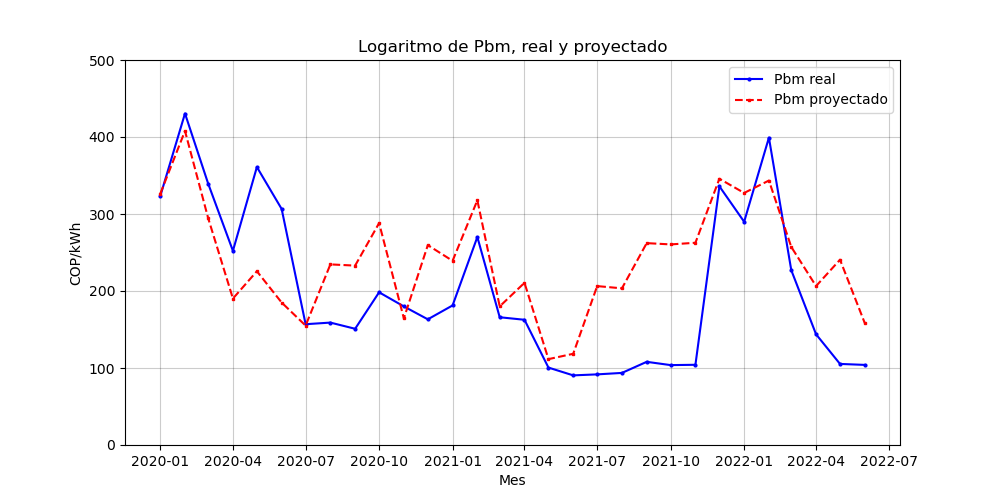

In [149]:
#*******************************************************************************
# 4.8.29. Grafica pbm real y proyectado en test.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Logaritmo de Pbm, real y proyectado')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(test.index, test.precio, 'b-o', \
    label='Pbm real', markersize=2)
ax1.plot(test.index, test.pbm_hat, 'r--s', \
    label='Pbm proyectado', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 500)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

### 4.8.3. Proyecta demanda

In [2]:
#*******************************************************************************
# 4.8.30. Calcula la regresión lineal de la demanda.
#*******************************************************************************
#Lee demanda_m
demanda_m = pd.read_parquet\
    ('parquet/demanda_m.parquet.gzip', engine='fastparquet')
demanda_m.demanda = demanda_m.demanda * 1e3
demanda_m.insert(loc=len(demanda_m.columns), column='nMes', \
    value=range(0, 270), allow_duplicates=False) 
m, b = np.polyfit(demanda_m.nMes, demanda_m.demanda, 1)
demanda_m.insert(loc=len(demanda_m.columns), column='regresion', \
    value=m*demanda_m.nMes + b, allow_duplicates=False) 
# aportes_m
# m, b
# m = 0.3537137022942708
# b = 110.97875816449749
# m * X + b

In [6]:
#*******************************************************************************
# 4.8.31. Crea DataFrame de proyección y lo integra a demanda_m.
#*******************************************************************************
demanda_m.insert(loc=len(demanda_m.columns), column='proyeccion', value=np.NaN, \
    allow_duplicates=True)

demanda_py = pd.DataFrame({'demanda': np.NaN, 'nMes': range(270, 348), \
    'regresion': np.NaN, 'proyeccion': np.NaN}, \
        index=pd.date_range(start='2022-07-01', periods = 78, freq='MS'))
demanda_py.index.name = 'Date'
demanda_py['proyeccion'] = (m*demanda_py.nMes + b)
# Integra.
demanda_py = demanda_m.append(demanda_py, ignore_index = False)

In [3]:
#*******************************************************************************       
# 4.8.32. Salva y lee demanda_py.
#*******************************************************************************
# #Salva demanda_py
# demanda_py.to_parquet\
#     ('parquet/demanda_py.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee demanda_py
demanda_py = pd.read_parquet\
    ('parquet/demanda_py.parquet.gzip', engine='fastparquet')

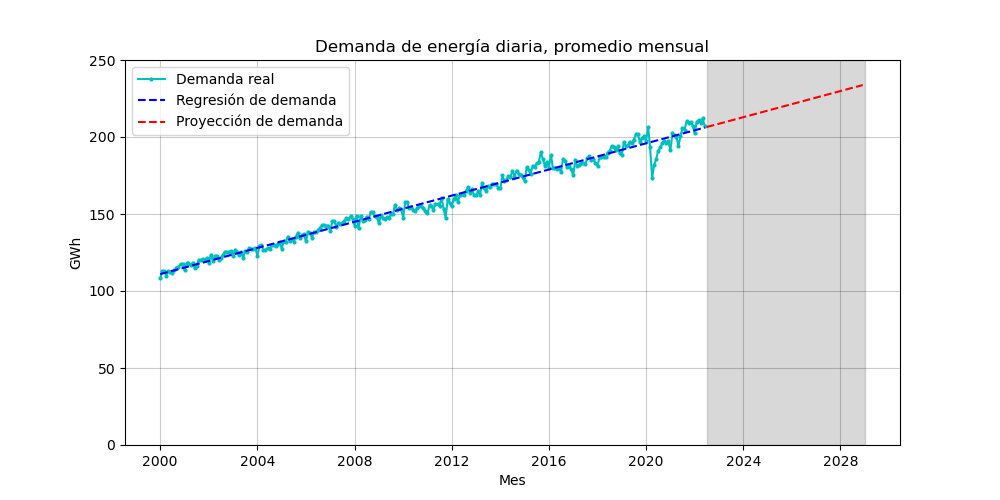

In [4]:
#*******************************************************************************
# 4.8.33. Grafica de demanda de energía diaria promedio mensual.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Demanda de energía diaria, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(demanda_py.index, demanda_py.demanda, 'c-o', \
    label='Demanda real', markersize=2)
ax1.plot(demanda_py.index, demanda_py.regresion, 'b--', \
    label='Regresión de demanda', markersize=2)
ax1.plot(demanda_py.index, demanda_py.proyeccion, 'r--', \
    label='Proyección de demanda', markersize=2)
# ax1.plot(test.index, test.pbm_hat, 'r--s', \
#     label='Pbm proyectado', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 250)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

### 4.8.4. Proyecta capacidad

In [221]:
#*******************************************************************************
# 4.8.34. Crea DataFrame de proyección y lo integra a capacidad_m.
#*******************************************************************************
#Lee capacidad_m
capacidad_m = pd.read_parquet\
    ('parquet/capacidad_m.parquet.gzip', engine='fastparquet')
capacidad_m.insert(loc=len(capacidad_m.columns), column='proyeccion', value=np.NaN, \
    allow_duplicates=True)
#
capacidad_py = pd.DataFrame({'capacidad': np.NaN, 'proyeccion': np.NaN}, \
        index=pd.date_range(start='2022-07-01', periods = 78, freq='MS'))
capacidad_py.index.name = 'Date'
capacidad_py['proyeccion'] = capacidad_m.iloc[269, 0]
#Integra.
capacidad_py = capacidad_m.append(capacidad_py, ignore_index = False)
#Agrega la nueva capacidad de Hidroituango de 2400 MW a partir de 2023-06-01
capacidad_py.loc[pd.to_datetime('2023-06-01') : pd.to_datetime('2028-12-01'), \
    ['proyeccion']] = (17.29361 + 2.4) 

In [222]:
capacidad_py

capacidad  proyeccion
Date                             
2000-01-01   7.246692         NaN
2000-02-01  15.587432         NaN
2000-03-01  15.587432         NaN
2000-04-01  15.587432         NaN
2000-05-01  15.587432         NaN
...               ...         ...
2028-08-01        NaN    19.69361
2028-09-01        NaN    19.69361
2028-10-01        NaN    19.69361
2028-11-01        NaN    19.69361
2028-12-01        NaN    19.69361

[348 rows x 2 columns]

In [223]:
#*******************************************************************************       
# 4.8.35. Salva y lee capacidad_py.
#*******************************************************************************
# #Salva capacidad_py
# capacidad_py.to_parquet\
#     ('parquet/capacidad_py.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee capacidad_py
capacidad_py = pd.read_parquet\
    ('parquet/capacidad_py.parquet.gzip', engine='fastparquet')

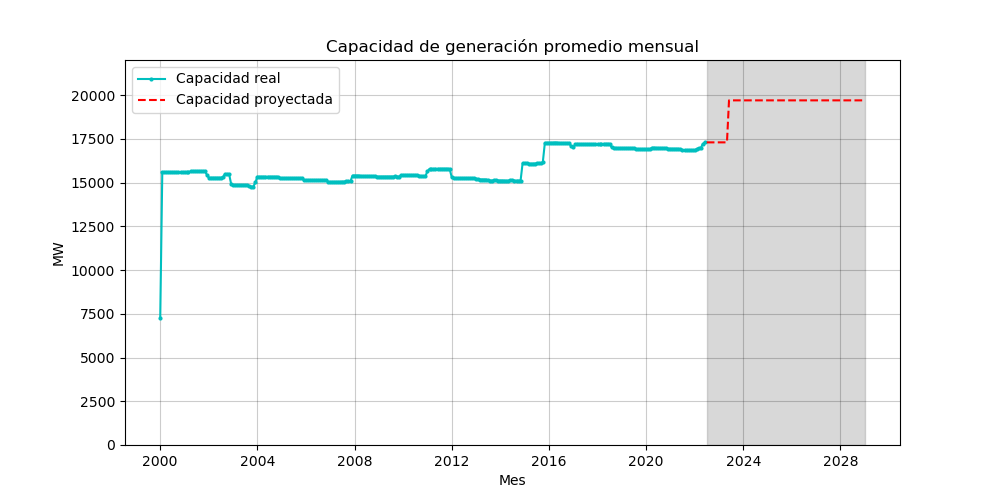

In [225]:
#*******************************************************************************
# 4.8.36. Grafica de capacidad de generación de energía diaria, promedio mensual.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Capacidad de generación promedio mensual')
ax1.set_ylabel ('MW')
ax1.set_xlabel ('Mes')
ax1.plot(capacidad_py.index, capacidad_py.capacidad * 1e3, 'c-o', \
    label='Capacidad real', markersize=2)
ax1.plot(capacidad_py.index, capacidad_py.proyeccion * 1e3, 'r--', \
    label='Capacidad proyectada', markersize=2)
# ax1.plot(demanda_m.index, demanda_m.regresion, 'b--', \
#     label='Regresión de demanda', markersize=2)
# ax1.plot(demanda_m.index, demanda_m.proyeccion, 'r--', \
#     label='Proyección de demanda', markersize=2)
# ax1.plot(test.index, test.pbm_hat, 'r--s', \
#     label='Pbm proyectado', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
#     label='Escenario de precios alto', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
#     label='Escenario de precios Medio', markersize=2)
# ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
#     label='Escenario de precios Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 22000)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

### 4.8.5. Prepara tres conjuntos de datos para proyección de pbm
Estos tres conjunto de datos (Alto, Medio y Bajo) contienen las variables explicativas proyectadas, que son las siguientes:
1. aporte_energia_escenarios, en tres Escenarios.
2. aportes_h, que nos permitirán calcular las diferencias de aportes en energía.
3. capacidad_py
4. demanda_py

In [5]:
#*******************************************************************************       
# 4.8.37. Lee las variables explicativas proyectadas.
#*******************************************************************************
aporte_energia_escenarios = pd.read_parquet\
    ('parquet/aporte_energia_escenarios.parquet.gzip', engine='fastparquet')
aportes_h = pd.read_parquet\
    ('parquet/aportes_h.parquet.gzip', engine='fastparquet')
#La relación es: aporEner = (aporCaudalRio * 0.0857) - 5.799 #m3/seg.
aportes_h.insert(loc=len(aportes_h.columns), column='aporEnerMediHist', \
    value=aportes_h.aporCaudalHistProy * 1e3 * 0.0857 - 5.799, allow_duplicates=True)
aportes_h = aportes_h.drop(columns=['aporCaudalMediHistRio', \
    'aporCaudalHistProy'], axis=1)
#Capacidad.
capacidad_py = pd.read_parquet\
    ('parquet/capacidad_py.parquet.gzip', engine='fastparquet')
capacidad_py = capacidad_py.drop(columns=['capacidad'], axis=1)
capacidad_py = capacidad_py[pd.to_datetime('2022-07-01'):pd.to_datetime('2029-01-01')]
capacidad_py = capacidad_py.rename(columns={'proyeccion': 'capacidad'})
#Demanda.
demanda_py = pd.read_parquet\
    ('parquet/demanda_py.parquet.gzip', engine='fastparquet')
demanda_py = demanda_py.drop(columns=['demanda', 'nMes', 'regresion'], axis=1)
demanda_py = demanda_py[pd.to_datetime('2022-07-01'):pd.to_datetime('2029-01-01')]
demanda_py = demanda_py.rename(columns={'proyeccion': 'demanda'})

In [6]:
#*******************************************************************************       
# 4.8.38. IntegraLee las variables explicativas proyectadas`en pbm_0`.
#*******************************************************************************
#1. Tres escenarios de aportes de energía.
pbm_0 = aporte_energia_escenarios.copy()
#2. Proyección de aportes de lluvias en caudales.
pbm_0 = pbm_0.join(aportes_h, how='left')
#3. Proyección de capacidad_py.
pbm_0 = pbm_0.join(capacidad_py, how='left')
#4. Proyección de demanda_py.
pbm_0 = pbm_0.join(demanda_py, how='left')

In [7]:
#*******************************************************************************       
# 4.8.39. Salva y lee pbm_0.
#*******************************************************************************
# #Salva pbm_0
# pbm_0.to_parquet\
#     ('parquet/pbm_0.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee pbm_0
pbm_0 = pd.read_parquet\
    ('parquet/pbm_0.parquet.gzip', engine='fastparquet')

In [8]:
#*******************************************************************************       
# 4.8.40. Crea los tres subconjuntos de proyección a partir de pbm_0.
#*******************************************************************************
pbm_alto = pbm_0.copy()
pbm_alto = pbm_alto[['aporteEnergiaAlto', 'aporEnerMediHist', 'capacidad', 'demanda']]
pbm_alto = pbm_alto.rename(columns={'aporteEnergiaAlto': 'aporEner'})
pbm_alto.aporEner = pbm_alto.aporEner/1e3
pbm_alto.aporEnerMediHist = pbm_alto.aporEnerMediHist/1e3
pbm_alto.demanda = pbm_alto.demanda/1e3
#
pbm_medio = pbm_0.copy()
pbm_medio = pbm_medio[['aporteEnergiaMedio', 'aporEnerMediHist', 'capacidad', 'demanda']]
pbm_medio = pbm_medio.rename(columns={'aporteEnergiaMedio': 'aporEner'})
pbm_medio.aporEner = pbm_medio.aporEner/1e3
pbm_medio.aporEnerMediHist = pbm_medio.aporEnerMediHist/1e3
pbm_medio.demanda = pbm_medio.demanda/1e3
#
pbm_bajo = pbm_0.copy()
pbm_bajo = pbm_bajo[['aporteEnergiaBajo', 'aporEnerMediHist', 'capacidad', 'demanda']]
pbm_bajo = pbm_bajo.rename(columns={'aporteEnergiaBajo': 'aporEner'})
pbm_bajo.aporEner = pbm_bajo.aporEner/1e3
pbm_bajo.aporEnerMediHist = pbm_bajo.aporEnerMediHist/1e3
pbm_bajo.demanda = pbm_bajo.demanda/1e3


### 4.8.6. Proyecta los tres precios de bolsa Pbm

In [9]:
#*******************************************************************************
# 4.8.41. Lee el modelo_ajustado_pbm_acd
#*******************************************************************************
#Lee el modelo_ajustado_pbm_acd
modelo_ajustado_pbm_acd = sm.load('modelos/modelo_ajustado_pbm_acd.pickle')

In [10]:
#*******************************************************************************
# 4.8.42. Calcula los valores proyectados y pasa de log a pbm.
#*******************************************************************************
valores_ajustados = modelo_ajustado_pbm_acd.predict(pbm_alto)
pbm_alto.insert(loc=len(pbm_alto.columns), column='pbm_alto', \
    value=np.exp(valores_ajustados), allow_duplicates=True)

valores_ajustados = modelo_ajustado_pbm_acd.predict(pbm_medio)
pbm_medio.insert(loc=len(pbm_medio.columns), column='pbm_medio', \
    value=np.exp(valores_ajustados), allow_duplicates=True)

valores_ajustados = modelo_ajustado_pbm_acd.predict(pbm_bajo)
pbm_bajo.insert(loc=len(pbm_bajo.columns), column='pbm_bajo', \
    value=np.exp(valores_ajustados), allow_duplicates=True)

In [11]:
#*******************************************************************************
# 4.8.43. Integra los pbm proyectados en pbm_py.
#*******************************************************************************
pbm_py = pbm_alto.copy()
pbm_py = pbm_py[['pbm_alto']]
pbm_py = pd.concat([pbm_py, pbm_medio[['pbm_medio']]], axis=1)
pbm_py = pd.concat([pbm_py, pbm_bajo[['pbm_bajo']]], axis=1)

In [12]:
#*******************************************************************************
# 4.8.44. Integra con pbm reales.
#*******************************************************************************
#Lee pbm_cee
pbm_cee = pd.read_parquet\
    ('parquet/pbm_cee.parquet.gzip', engine='fastparquet')
pbm_cee = pbm_cee.drop(columns=['cee', 'cere', 'pbm_log', 'pbm_sc', 'pbm_sc_log'], axis=1)
pbm_cee = pbm_cee.rename(columns={'precio': 'pbm'})

pbm_py = pbm_py.join(pbm_cee, how='outer')

In [13]:
#*******************************************************************************
# 4.8.45. Carga datos en '2022-06-01.
#*******************************************************************************
pbm_py.loc[pd.to_datetime('2022-06-01'), \
    ['pbm_alto', 'pbm_medio', 'pbm_bajo']]  = \
        pbm_cee.loc[pd.to_datetime('2022-06-01'), 'pbm']


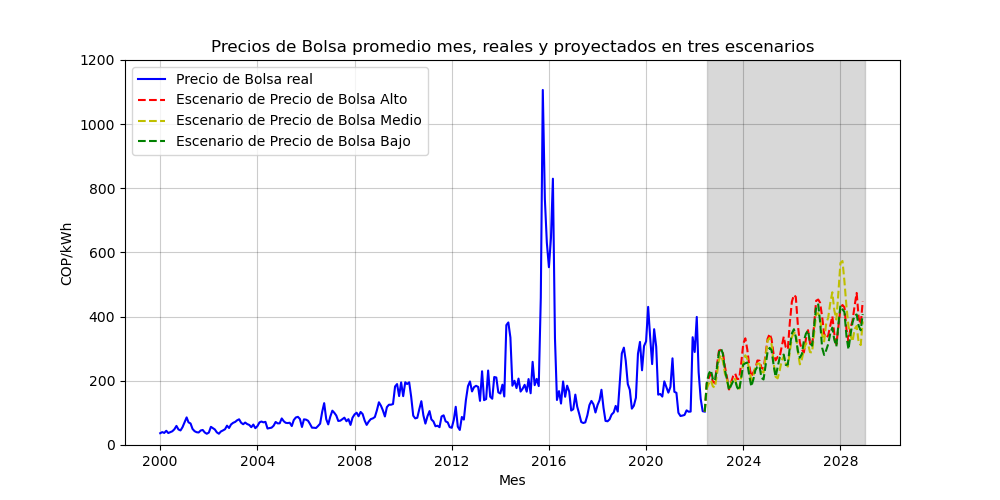

In [14]:
#*******************************************************************************
# 4.8.46. Grafica los pbm reales y proyectados en tres escenarios.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Precios de Bolsa promedio mes, reales y proyectados en tres escenarios')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(pbm_py.index, pbm_py.pbm, 'b-', \
    label='Precio de Bolsa real', markersize=2)
ax1.plot(pbm_py.index, pbm_py.pbm_alto, 'r--', \
    label='Escenario de Precio de Bolsa Alto', markersize=2)
ax1.plot(pbm_py.index, pbm_py.pbm_medio, 'y--', \
    label='Escenario de Precio de Bolsa Medio', markersize=2)
ax1.plot(pbm_py.index, pbm_py.pbm_bajo, 'g--', \
    label='Escenario de Precio de Bolsa Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 1200)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

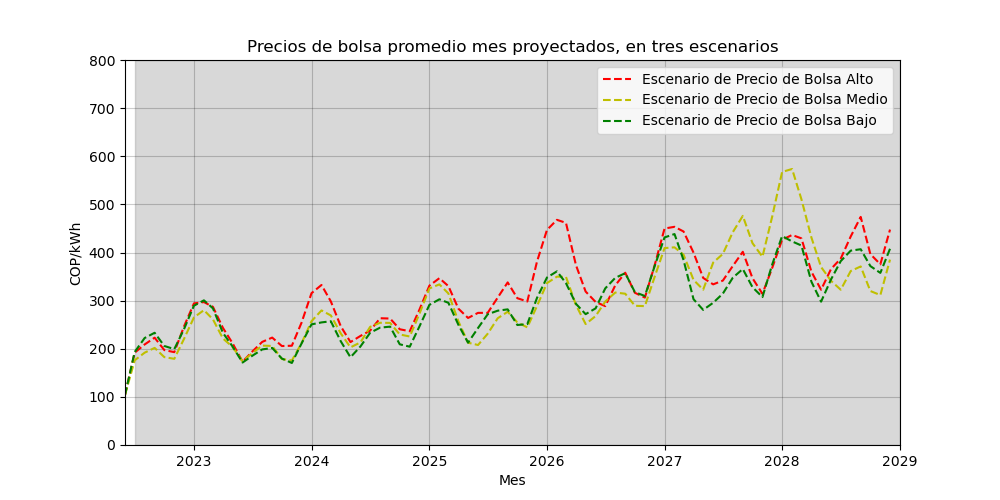

In [15]:
#*******************************************************************************
# 4.8.47. Grafica los pbm proyectados en tres escenarios.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Precios de bolsa promedio mes proyectados, en tres escenarios')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
# ax1.plot(pbm_py.index, pbm_py.pbm, 'b-', \
#     label='Precio de Bolsa real', markersize=2)
ax1.plot(pbm_py.index, pbm_py.pbm_alto, 'r--', \
    label='Escenario de Precio de Bolsa Alto', markersize=2)
ax1.plot(pbm_py.index, pbm_py.pbm_medio, 'y--', \
    label='Escenario de Precio de Bolsa Medio', markersize=2)
ax1.plot(pbm_py.index, pbm_py.pbm_bajo, 'g--', \
    label='Escenario de Precio de Bolsa Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
     color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 800)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [20]:
pbm_py_f = pbm_py.copy() #Proyección pbm final.

In [21]:
#*******************************************************************************       
# 4.8.48. Salva y lee pbm_py.
#*******************************************************************************
# # #Salva pbm_py-f
# pbm_py_f.to_parquet\
#     ('parquet/pbm_py_f.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee pbm_py
pbm_py_f = pd.read_parquet\
    ('parquet/pbm_py_f.parquet.gzip', engine='fastparquet')

## 4.9. Proyección del IPP
Para poder calcular los precios futuros, que permiten estimar los egresos de energía, se debe realizar una proyección del IPP, ya que los componentes de los precios de las ofertas (cargo C de comercialización y el precio fijo) están expresados en pesos de abril de 2022. Estos precios se deben ajustar mensualmente.

### 4.9.1. Obtiene el IPP mensual del DANE

In [42]:
#*******************************************************************************       
# 4.9.1. Obtiene el IPP histórico.
#*******************************************************************************
ipp = pd.read_excel("xlsx/anexo_ipp1_jul22.xlsx", sheet_name='IPP Histórico', \
    skiprows=4, skipfooter=9, usecols=[0, 1, 6])
ipp.insert(loc=len(ipp.columns), column='Date', \
    value=pd.date_range(start='1999-06-01', end='2022-07-01', freq='MS'), \
        allow_duplicates=False)
ipp = ipp.set_index('Date')
ipp.columns = ['columna1', 'columna2', 'ipp']
ipp = ipp.drop(columns=['columna1', 'columna2'], axis=1)

In [3]:
#*******************************************************************************       
# 4.9.2. Salva y lee el IPP.
#*******************************************************************************
# # #Salva pbm_py-f
# ipp.to_parquet\
#     ('parquet/ipp.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee ipp
ipp = pd.read_parquet\
    ('parquet/ipp.parquet.gzip', engine='fastparquet')

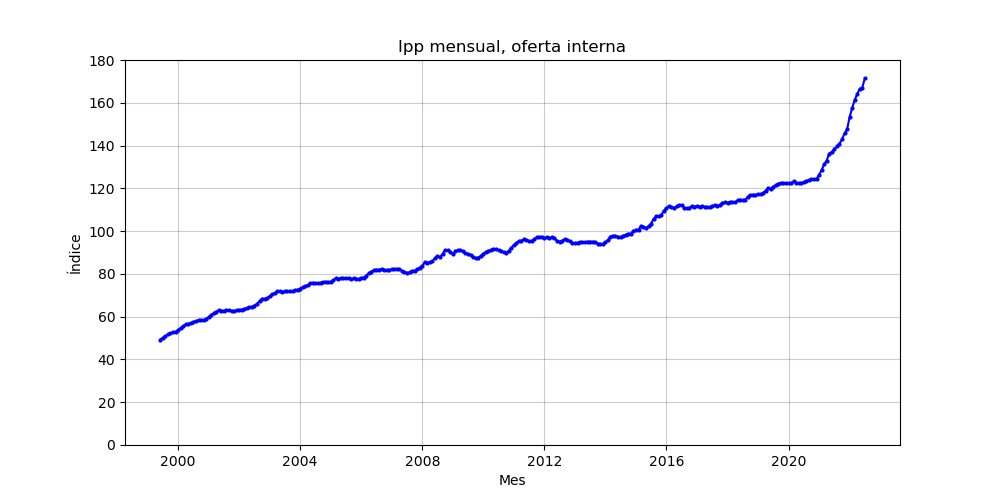

In [4]:
#*******************************************************************************
# 4.9.3. Grafica el IPP.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Ipp mensual, oferta interna')
ax1.set_ylabel ('Índice')
ax1.set_xlabel ('Mes')
ax1.plot(ipp.index, ipp.ipp, 'b-o', \
    label='Ipp', markersize=2)
# plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 180)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

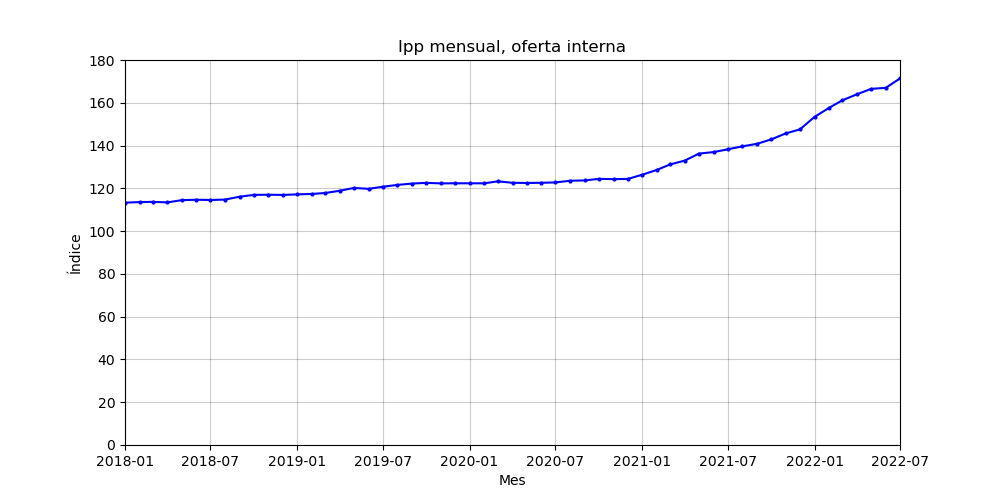

In [5]:
#*******************************************************************************
# 4.9.4. Grafica el IPP desde 2021.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Ipp mensual, oferta interna')
ax1.set_ylabel ('Índice')
ax1.set_xlabel ('Mes')
ax1.plot(ipp.index, ipp.ipp, 'b-o', \
    label='Ipp', markersize=2)
# plt.legend(loc='best')
plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 180)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [6]:
#*******************************************************************************
# 4.9.5. Calcula dos regresiones de Ipp. Una hasta 2020-12 y otra en adelante.
#*******************************************************************************
#Regresion99
ipp.insert(loc=len(ipp.columns), column='n_mes99', value=range(0, 278), \
    allow_duplicates=False)
#Regresión de 1999-06 a 2020-12
m99, b99 = np.polyfit(\
    ipp.loc[pd.to_datetime('1999-06-01'):pd.to_datetime('2020-12-01'), :].\
        n_mes99, ipp.loc[pd.to_datetime('1999-06-01'):\
            pd.to_datetime('2020-12-01'), :].ipp, 1)
ipp.insert(loc=len(ipp.columns), column='regresion99', \
    value=(ipp.n_mes99 * m99 + b99), allow_duplicates=True) 
ipp.loc[pd.to_datetime('2021-01-01'):pd.to_datetime('2022-07-01'), 'regresion99'] = np.NaN
#m21: 0.25%
#************************
#Regresion21
ipp.insert(loc=len(ipp.columns), column='n_mes21', value=np.NaN, \
    allow_duplicates=True)
#Regresión de 2021-12 a 2022-07
ipp.loc[pd.to_datetime('2021-01-01'):pd.to_datetime('2022-07-01'), 'n_mes21'] = range(0, 19)
m21, b21 = np.polyfit(\
    ipp.loc[pd.to_datetime('2021-01-01'):pd.to_datetime('2022-07-01'), :].\
        n_mes21, ipp.loc[pd.to_datetime('2021-01-01'):\
            pd.to_datetime('2022-07-01'), :].ipp, 1)
ipp.insert(loc=len(ipp.columns), column='regresion21', \
    value=(ipp.n_mes21 * m21 + b21), allow_duplicates=True)
#m21: 2,5%

In [7]:
#*******************************************************************************
# 4.9.6. Proyección hasta 2028-12.
#*******************************************************************************
#proyeccion28
proyeccion28 = pd.DataFrame({'n_mes28': range(17, 96)}, \
    index=pd.date_range(start=('2022-06-01'), end=('2028-12-01'), freq='MS'))
proyeccion28.insert(loc=len(proyeccion28.columns), column='proyeccion28', \
    value=proyeccion28.n_mes28 * m21 + b21, allow_duplicates=True)
ipp = ipp.join(proyeccion28, how='outer')
ipp_py = ipp.copy()

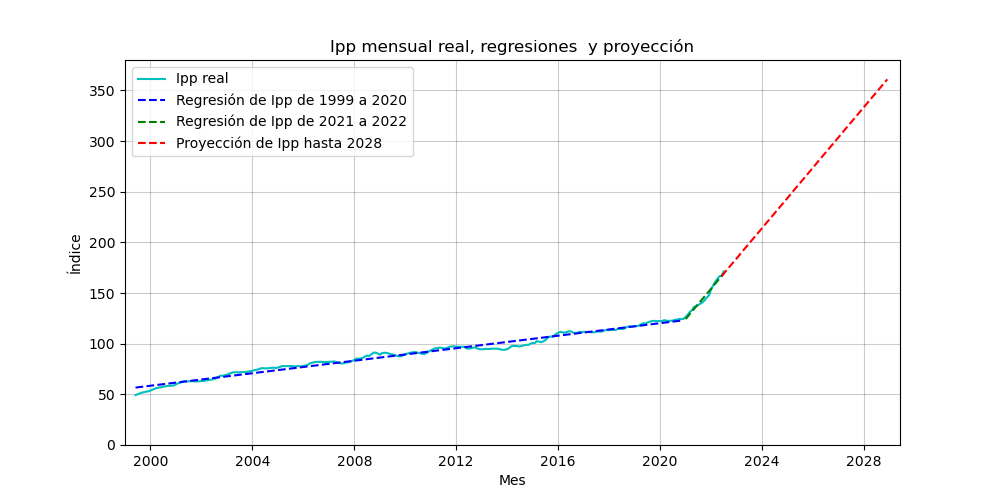

In [8]:
#*******************************************************************************
# 4.9.7. Grafica el IPP.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Ipp mensual real, regresiones  y proyección')
ax1.set_ylabel ('Índice')
ax1.set_xlabel ('Mes')
ax1.plot(ipp_py.index, ipp_py.ipp, 'c-', \
    label='Ipp real', markersize=2)
ax1.plot(ipp_py.index, ipp_py.regresion99, 'b--', \
    label='Regresión de Ipp de 1999 a 2020', markersize=2)
ax1.plot(ipp_py.index, ipp_py.regresion21, 'g--', \
    label='Regresión de Ipp de 2021 a 2022', markersize=2)
ax1.plot(ipp_py.index, ipp_py.proyeccion28, 'r--', \
    label='Proyección de Ipp hasta 2028', markersize=2)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('1999-01-01'), pd.to_datetime('2029-06-01'))
plt.ylim(0, 380)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [160]:
#*******************************************************************************       
# 4.9.8. Salva y lee el ipp_py (proyectado).
#*******************************************************************************
# # #Salva ipp_py
# ipp_py.to_parquet\
#     ('parquet/ipp_py.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee ipp
ipp_py = pd.read_parquet\
    ('parquet/ipp_py.parquet.gzip', engine='fastparquet')

In [9]:
ipp

ipp  n_mes99  regresion99  n_mes21  regresion21  n_mes28  \
1999-06-01  49.29      0.0    56.672732      NaN          NaN      NaN   
1999-07-01  50.14      1.0    56.930066      NaN          NaN      NaN   
1999-08-01  50.93      2.0    57.187400      NaN          NaN      NaN   
1999-09-01  51.67      3.0    57.444734      NaN          NaN      NaN   
1999-10-01  52.16      4.0    57.702068      NaN          NaN      NaN   
...           ...      ...          ...      ...          ...      ...   
2028-08-01    NaN      NaN          NaN      NaN          NaN     91.0   
2028-09-01    NaN      NaN          NaN      NaN          NaN     92.0   
2028-10-01    NaN      NaN          NaN      NaN          NaN     93.0   
2028-11-01    NaN      NaN          NaN      NaN          NaN     94.0   
2028-12-01    NaN      NaN          NaN      NaN          NaN     95.0   

            proyeccion28  
1999-06-01           NaN  
1999-07-01           NaN  
1999-08-01           NaN  
1999-09-01           NaN  
1999-10-01           NaN  
...                  ...  
2028-08-01    350.956281  
2028-09-01    353.446614  
2028-10-01    355.936947  
2028-11-01    358.427281  
2028-12-01    360.917614  

[355 rows x 7 columns]

In [11]:
m99, b99

(0.25733388358969744, 56.67273210573214)